In [1]:
library(tidyverse)
library(ggrepel)
library(latex2exp)
library(here)
library(bodkanr)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 2.2.1     ✔ purrr   0.2.5
✔ tibble  1.4.2     ✔ dplyr   0.7.5
✔ tidyr   0.8.1     ✔ stringr 1.3.1
✔ readr   1.1.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
here() starts at /mnt/expressions/mp/nea-over-time

Attaching package: ‘bodkanr’

The following object is masked from ‘package:ggplot2’:

    %+%



In [2]:
dir.create(here("figures"), showWarnings = FALSE)

In [3]:
# Near East populations to exclude from the plots containing Europeans
near_east <- c("BedouinB", "Yemenite_Jew", "Palestinian", "Iraqi_Jew", "Jordanian",
               "Druze", "Iranian", "Samaritan")
ignore_samples <- near_east

# load the estimates
admix_array <- readRDS(here("data/rds/admixture_array_prop.rds")) %>% filter(!X %in% ignore_samples) %>% mutate(stat = "admix_prop")
f4_nea <- readRDS(here("data/rds/f4_nea.rds")) %>% filter(!X %in% ignore_samples)

nea_est_all <- bind_rows(admix_array, f4_nea) %>% select(X, stat, alpha, Zscore, snp_count, age, pop, stderr, sites)
nea_est <- nea_est_all %>% filter(pop %in% c("EMH", "WestEurasia"))

In [4]:
plot_nea_time <- function(df, statistic, array, snp_cutoff = 0, ymax = 0.05, title = "",
                          statistic.2 = NULL, array.2 = NULL,
                          ret.fit.2 = FALSE) {
  p1 <- filter(df,
         stat == statistic,
         sites == array,
         pop %in% c("EMH", "WestEurasia"),
         snp_count > snp_cutoff) %>% 
    ggplot(aes(age, alpha)) +
    geom_point(aes(size = snp_count/1e6), alpha = 1/2) +
    geom_errorbar(aes(ymin = alpha - 2 * stderr, ymax = alpha + 2 * stderr), alpha = 1/5) +
    geom_smooth(aes(weight = snp_count), method = "lm", linetype = 2, 
                fullrange = TRUE, size = 0.5, color="blue") +
    coord_cartesian(ylim = c(0, ymax)) +
    xlim(46000, 0) +
    xlab("Years before present") + ylab("Neandertal ancestry proportion") +
    ggtitle(title) +
    scale_size("SNP count\n(million)") + theme_classic()
  if (!is.null(statistic.2)) {
    p2 <- filter(df,
                 stat == statistic.2,
                 sites == array.2,
                 pop %in% c("EMH", "WestEurasia"),
                 snp_count > snp_cutoff) %>% 
      geom_smooth(mapping = aes(weight = snp_count), method = "lm", linetype = 3, 
                  fullrange = TRUE, size = 0.5, color="black", se=F)
    if (ret.fit.2) return(p2)
    return(p1+p2)
  }
  return(p1)
}

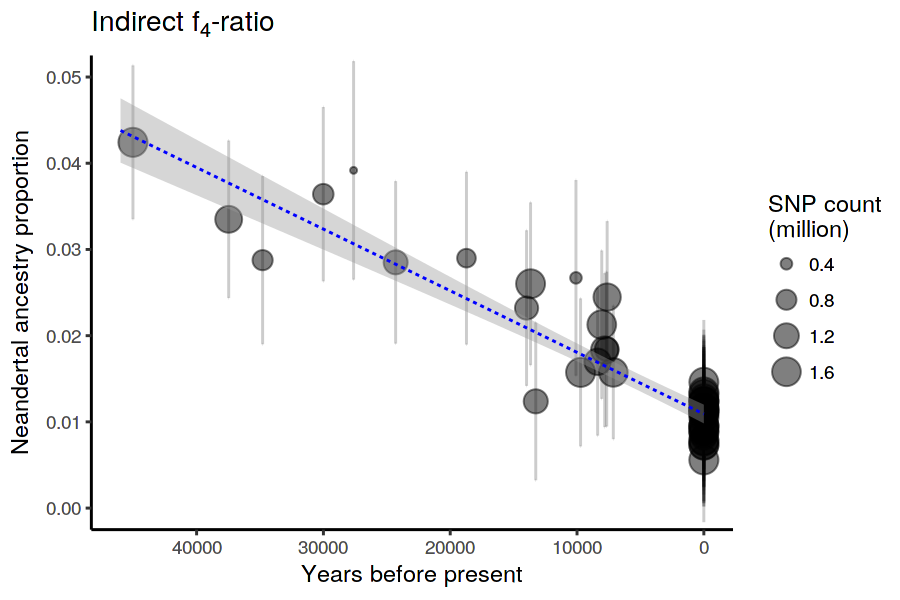

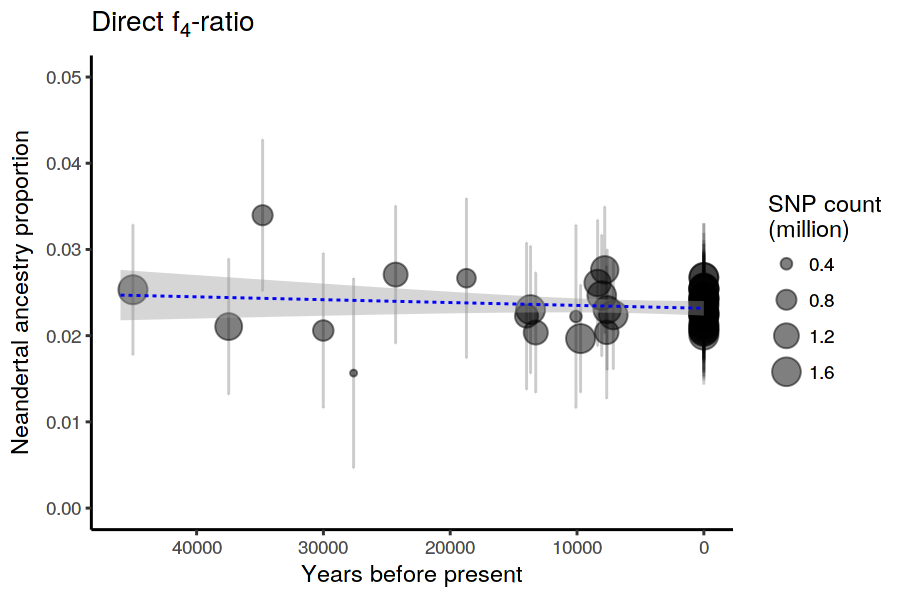

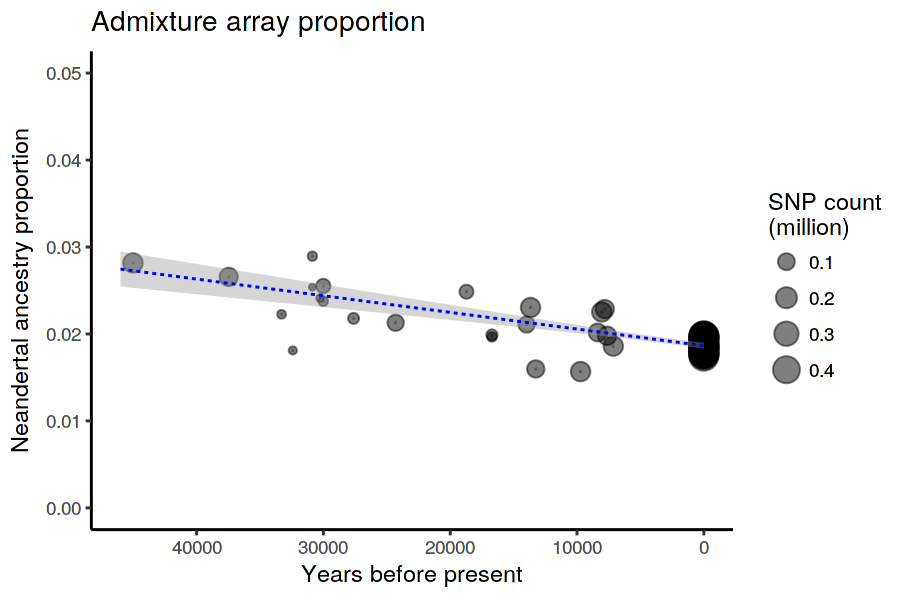

In [5]:
set_dim(6, 4)

plot_nea_time(nea_est, statistic = "indirect_f4", array = "all",
              snp_cutoff = 1000, title = TeX("Indirect $f_4$-ratio"))
ggsave(here("figures/fig1a_indirect_f4.png"), width = 5, height = 3.5, units = "in")

plot_nea_time(nea_est, statistic = "direct_f4", array = "all",
              snp_cutoff = 1000, title = TeX("Direct $f_4$-ratio"))
ggsave(here("figures/fig1b_direct_f4.png"), width = 5, height = 3.5, units = "in")

plot_nea_time(nea_est, statistic = "admix_prop", array = "admixture_array",
              snp_cutoff = 1000, title = "Admixture array proportion")
#ggsave(here("figures/figS1a_admix_array_prop.png"), width = 5, height = 3.5, units = "in")

## EMH basal Eurasian signal

In [6]:
basal_eur <- readRDS(here("data/rds/array_basal_eur.rds"))

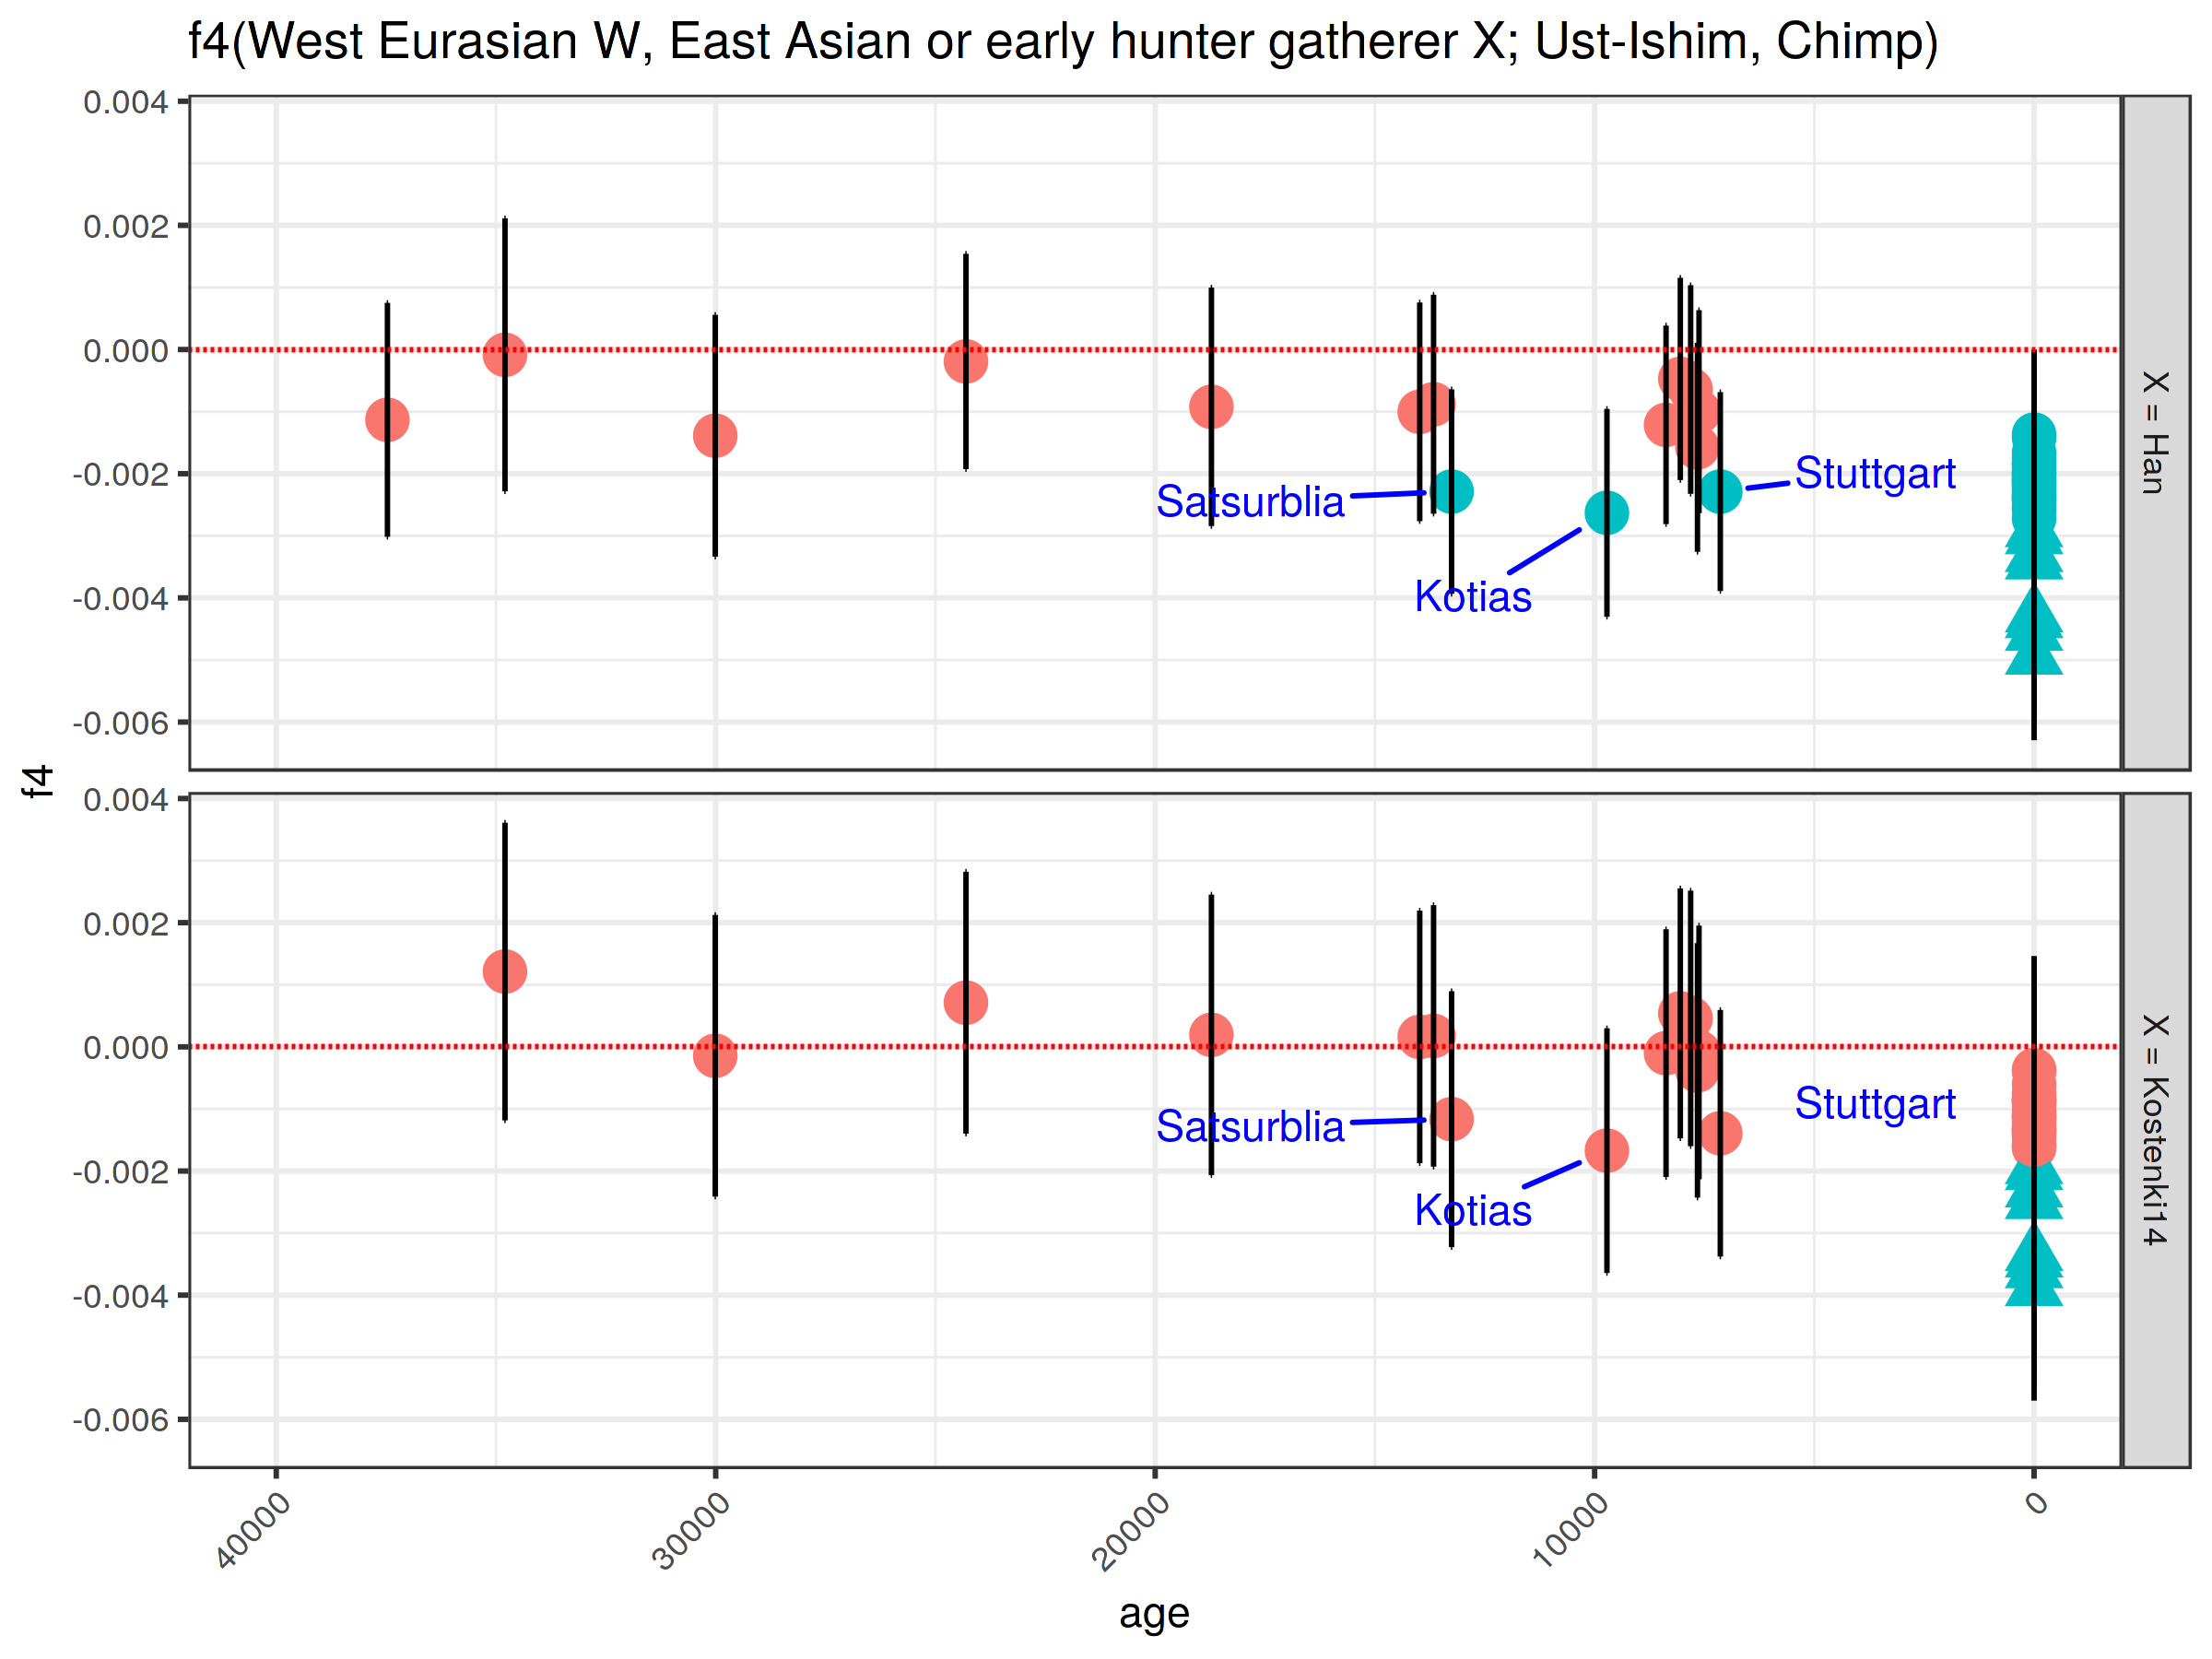

In [7]:
set_dim(8, 6, 300)

basal_eur %>% filter(snp_count > 500000) %>%
mutate(lbl = ifelse(W %in% c("Stuttgart", "Satsurblia", "Kotias"), W, ""),
       X = paste("X =", X)) %>% 
  ggplot(aes(age, f4)) +
  geom_point(aes(shape = W %in% near_east, color = abs(Zscore) > 3), size = 5) +
  geom_errorbar(aes(ymin = f4 - 3 * stderr, ymax = f4 + 3 * stderr)) +
  geom_hline(yintercept = 0, linetype = 2, color = "red") +
  geom_text_repel(aes(label = lbl), box.padding = 0.35, point.padding = 1, color = "blue") +
  ggtitle("f4(West Eurasian W, East Asian or early hunter gatherer X; Ust-Ishim, Chimp)") +
  theme_bw() +
  theme(legend.position = "none", axis.text.x = element_text(hjust = 1, angle = 45)) +
  facet_grid(X ~ .) +
  xlim(40000, 0)

ggsave(here("figures/figS1_basal_eurasian_over_time.png"), width = 8, height = 5, units = "in")

## Whole-genome basal Eurasian analysis

## Affinities over time to different SGDP populations

In [8]:
sgdp_affinities <- readRDS(here("data/rds/sgdp_affinities_ui_chimp.rds"))

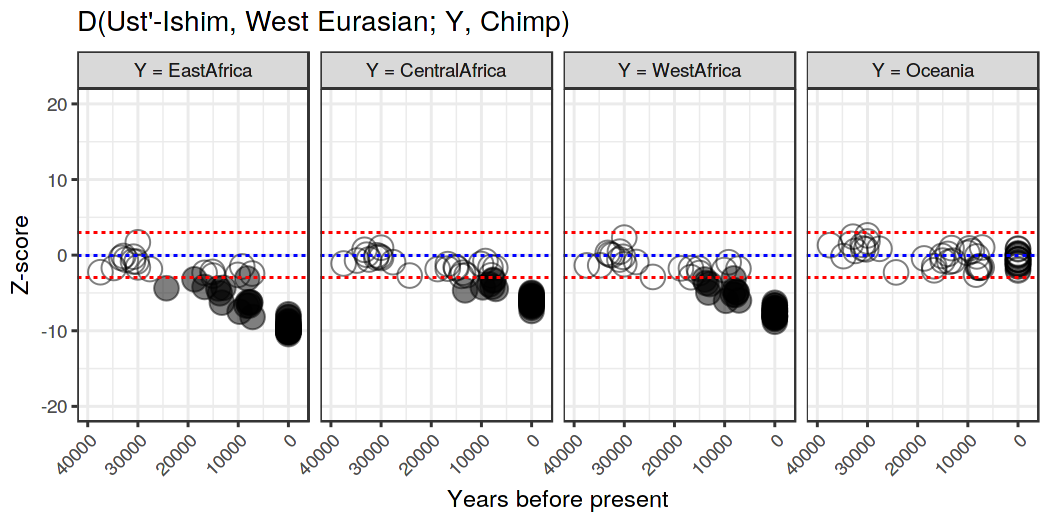

In [9]:
set_dim(7, 3.5)

sgdp_affinities %>% 
  filter(Y %in% c("EastAfrica", "CentralAfrica", "WestAfrica", "Oceania"), 
         n_snps > 50000) %>%
  mutate(Y = paste("Y =", Y)) %>% 
  mutate(Y = factor(Y, levels = c("Y = EastAfrica", "Y = CentralAfrica", "Y = WestAfrica", "Y = Oceania"))) %>%
  ggplot(aes(age, Zscore)) + geom_point(aes(shape = abs(Zscore) > 3), size = 5, alpha = 1/2) +
  geom_hline(yintercept = 0, linetype = 2, color = "blue") +
  geom_hline(yintercept = c(-3, 3), linetype = 2, color = "red") +
  xlim(40000, -2000) + ylim(-20, 20) +
  facet_grid(. ~ Y) +
  xlab("Years before present") + ylab("Z-score") +
  ggtitle("D(Ust'-Ishim, West Eurasian; Y, Chimp)") +
  scale_shape_manual(values = c(21, 19)) +
  theme_bw() + theme(legend.position = "none", axis.text.x = element_text(hjust = 1, angle = 45))

ggsave(here("figures/fig2_african_affinities_ui_chimp_oceania.png"),
       width = 7, height = 3.5, units = "in")

## SLiM trajectory average

In [10]:
mutations <- readRDS(here("data/rds/mutations.rds"))

mutation_traj <- mutations %>%
  filter(mut_type %in% c("gap_marker", "region_marker")) %>% 
  group_by(gen, rep, mut_type) %>%
  summarise(avg_nea=mean(freq)) %>%
  group_by(gen, mut_type) %>%
  summarise(mean_rep=mean(avg_nea), sd_rep=sd(avg_nea), n_rep=n()) %>%
  mutate(se_rep=sd_rep / sqrt(n_rep),
         lower_ci=mean_rep - qt(1 - (0.05 / 2), n_rep - 1) * se_rep,
         upper_ci=mean_rep + qt(1 - (0.05 / 2), n_rep - 1) * se_rep)

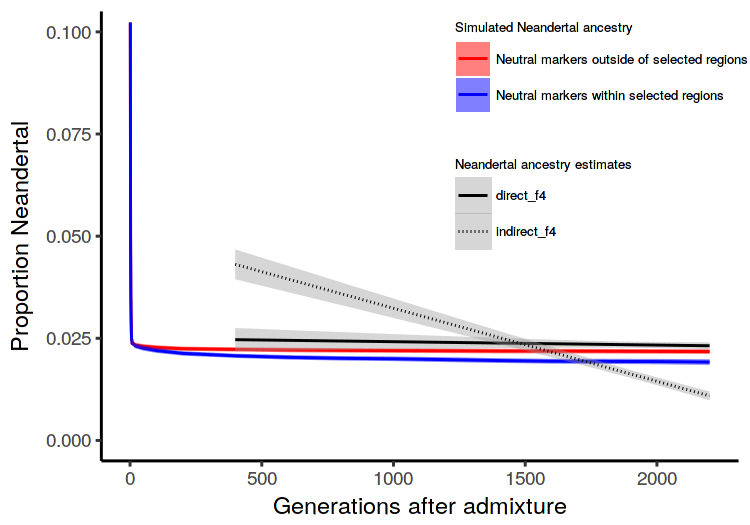

In [24]:
set_dim(5, 3.5)

p1 <- ggplot(mutation_traj, aes(gen, mean_rep)) +
  geom_line(size = 0.5, aes(color=mut_type, group = mut_type)) +
  geom_ribbon(aes(ymin=lower_ci, ymax=upper_ci, color=mut_type, group = mut_type, fill = mut_type), color = NA, alpha=1/2) +
  xlab("Generations after admixture") + ylab("Proportion Neandertal") +
  coord_cartesian(y=c(0, 0.1))

both_f4 <- filter(nea_est,
                 stat %in% c('indirect_f4', 'direct_f4'),
                 sites == 'all',
                 pop %in% c("EMH", "WestEurasia"),
                 snp_count > 1000) %>%
  mutate(gen = 2200 - age/25)

p1a <- geom_smooth(data=both_f4, 
                   mapping=aes(x = gen, y = alpha, weight=snp_count, lty=stat), inherit.aes = FALSE,
              method='lm', color='black', size=.5)

p1+p1a + theme_classic() +
  theme(legend.position = c(1,1), legend.justification = c(1,1), 
        legend.text = element_text(size=6), 
        legend.title = element_text(size=6)) +
  scale_color_manual('Simulated Neandertal ancestry',
                     values = c('red', 'blue'),
                     labels= c('Neutral markers outside of selected regions', 
                              'Neutral markers within selected regions')) +
  scale_fill_manual('Simulated Neandertal ancestry',
                     values = c('red', 'blue'),
                     labels= c('Neutral markers outside of selected regions', 
                               'Neutral markers within selected regions')) +
scale_linetype_manual('Neandertal ancestry estimates',
                   values = c(1, 3))
ggsave(here('figures/fig4b_SLiM_vs_f4.png'), width = 5, height = 3.5)

## Efficacy of negative selection vs distance to functional regions

In [12]:
bin_props <- readRDS(here("data/rds/depletion_near_genes.rds"))

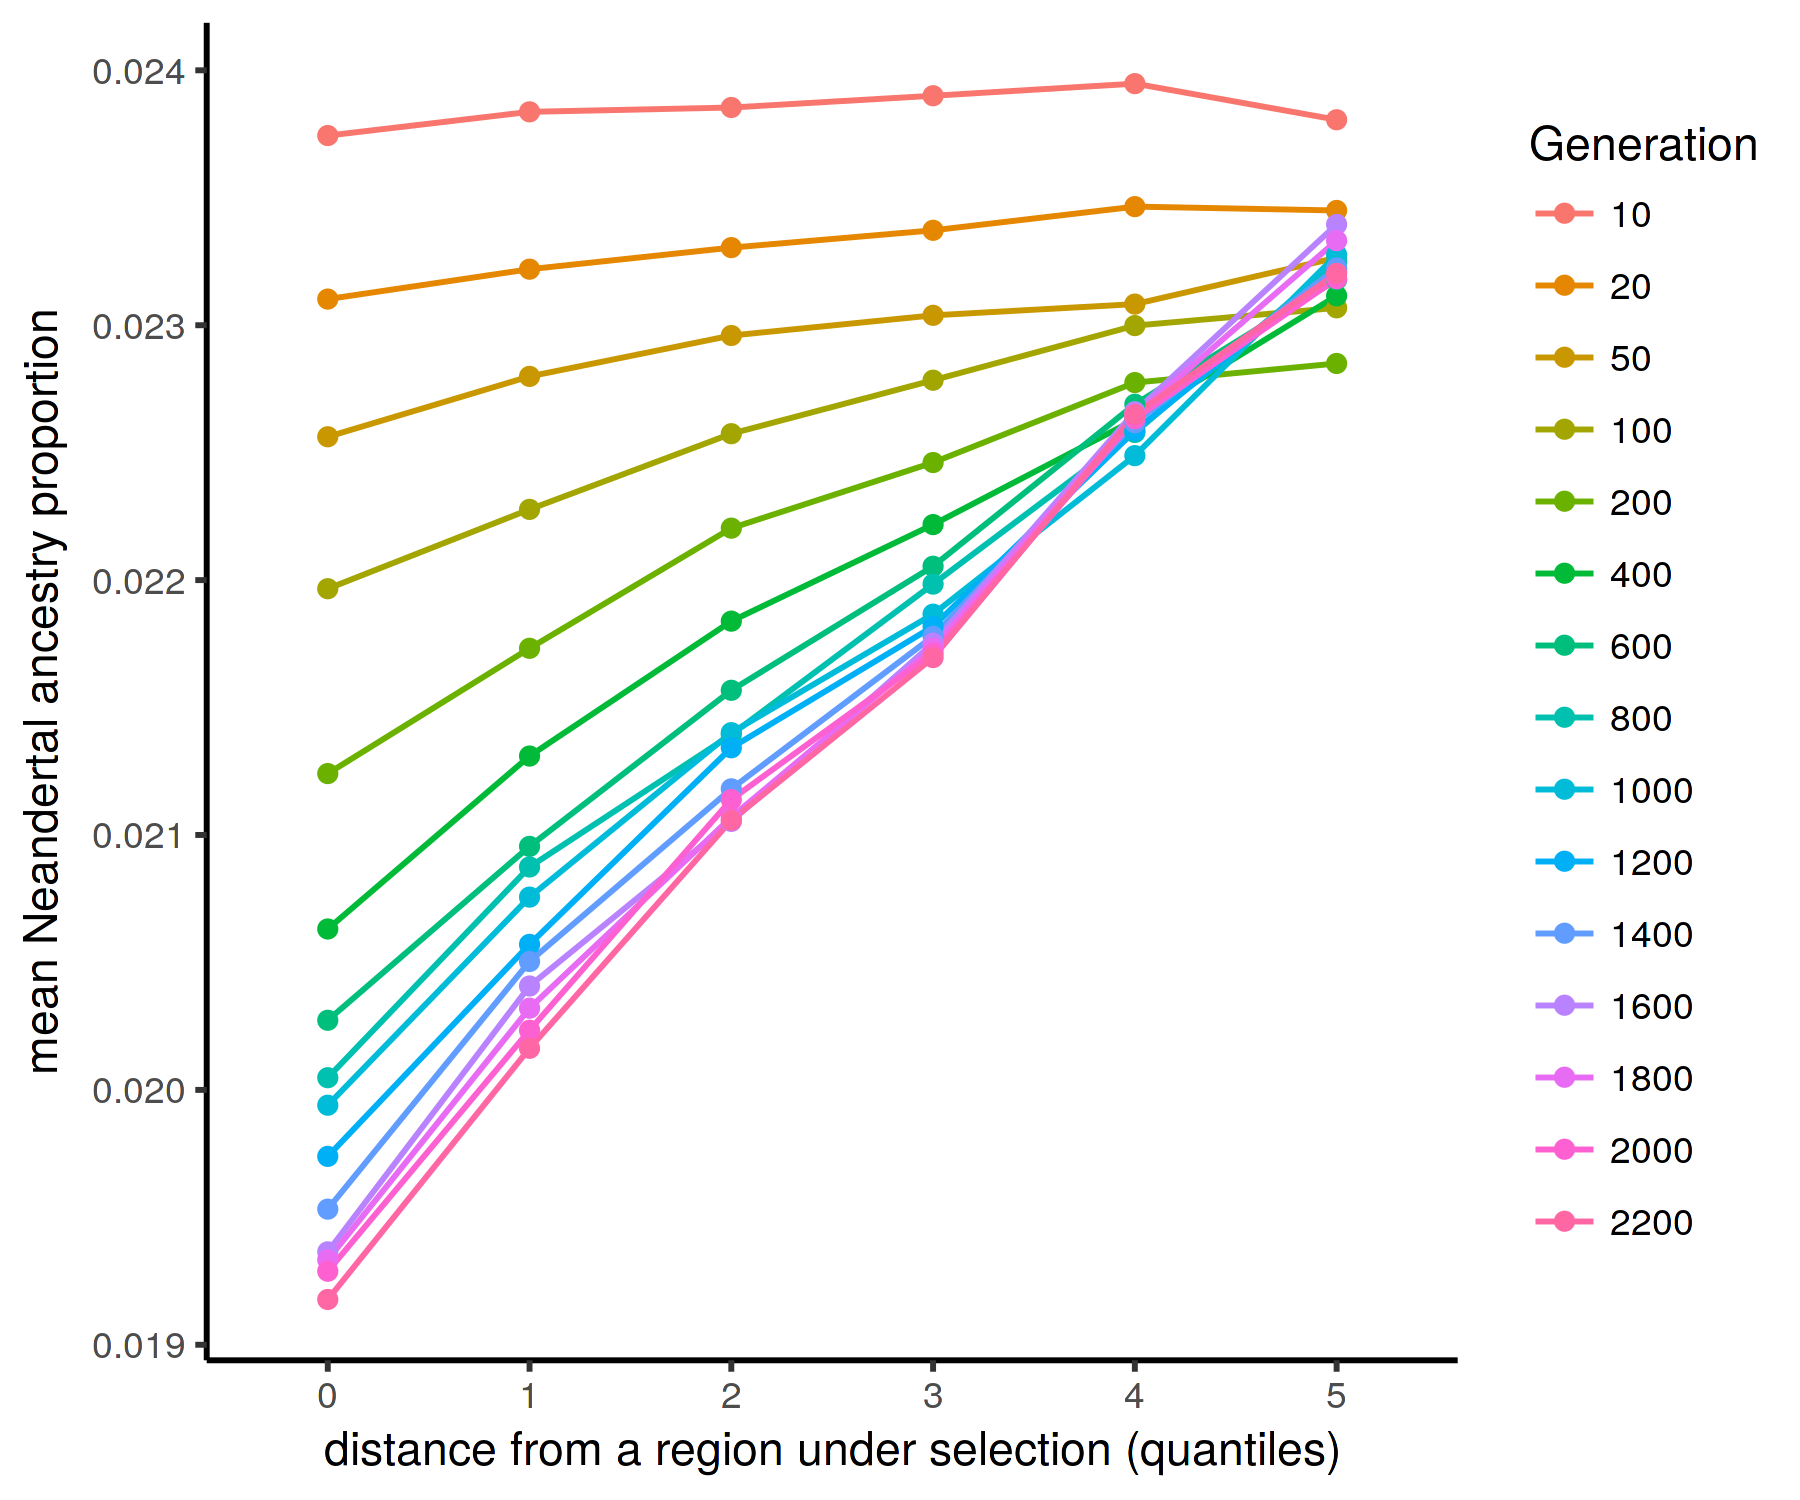

In [13]:
set_dim(6, 5, 300)

bin_props %>%
  group_by(dist_bin, gen) %>%
  summarise(nea_prop = mean(nea_prop)) %>% 
ggplot(aes(x=dist_bin, y=nea_prop, group=gen, color=as.factor(gen))) +
  geom_line() + 
  geom_point() +
  theme_classic() +
  xlab("distance from a region under selection (quantiles)") +
  ylab("mean Neandertal ancestry proportion") +
  scale_color_discrete(name = "Generation")

ggsave(here("figures/fig4c_depletion_near_exons.png"), width = 6, height = 5, units = "in")

## Deltas of allele frequencies over time

In [14]:
deltas <- readRDS(here("data/rds/mutation_deltas.rds"))

`geom_smooth()` using method = 'loess'


`geom_smooth()` using method = 'loess'


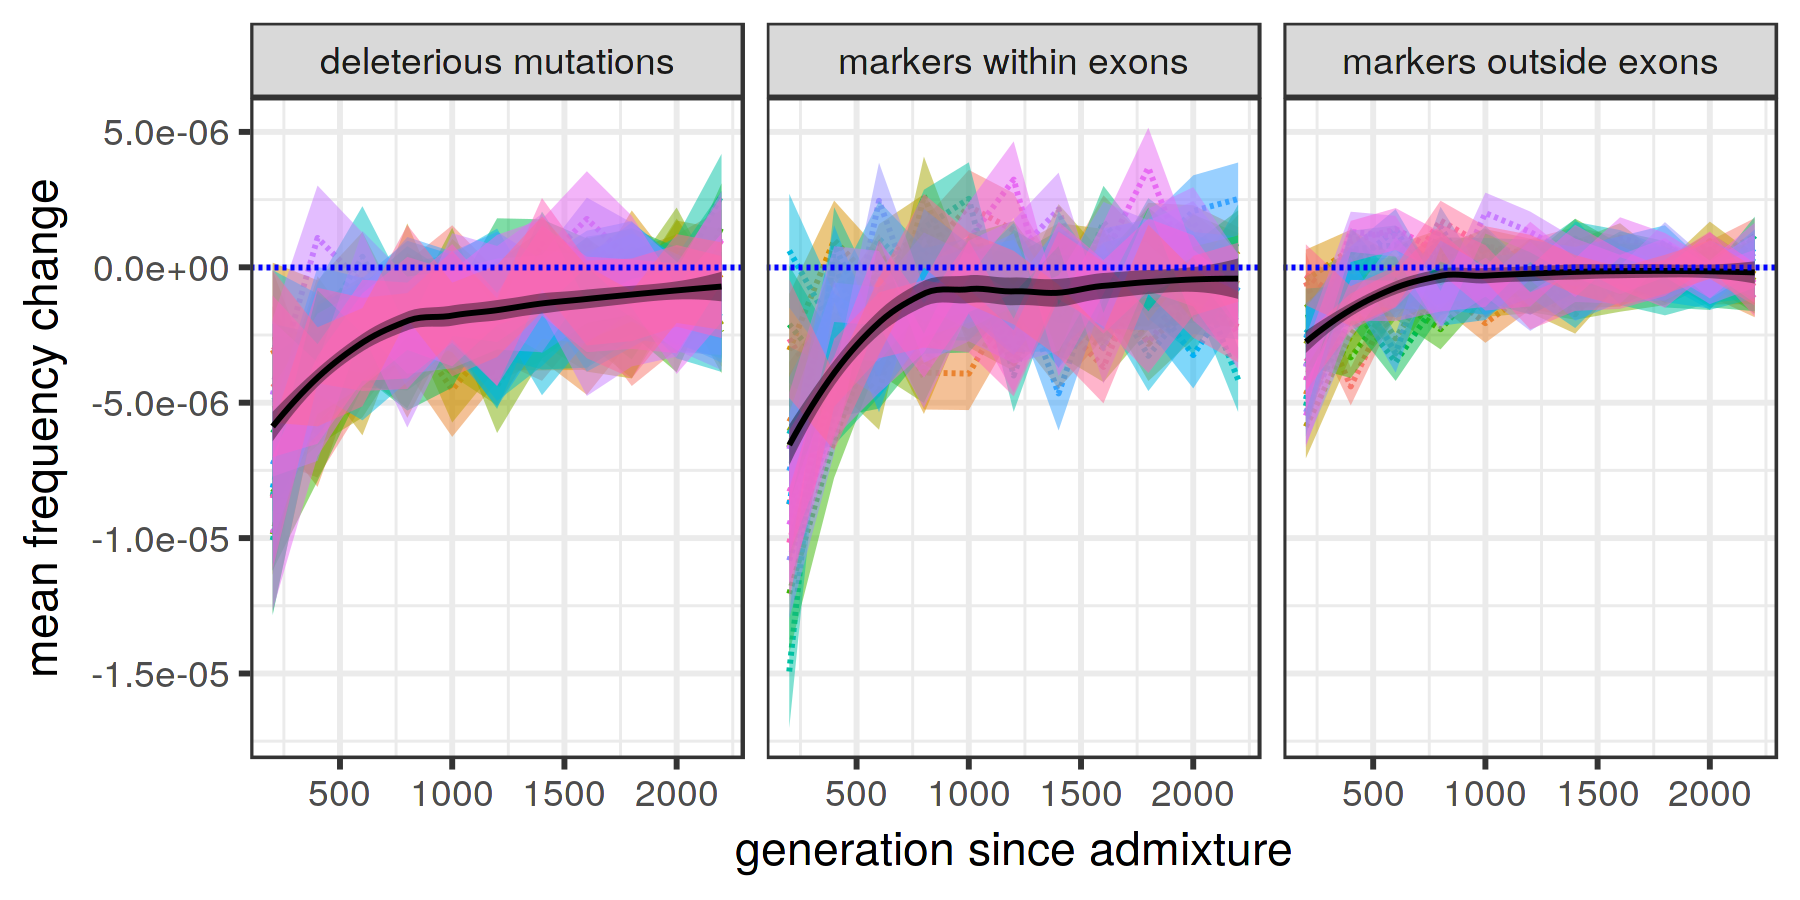

In [15]:
set_dim(6, 3, 300)

group_by(deltas, g, mut_type, rep) %>%    
  summarise(avg_delta=mean(delta_f), sd_delta=sd(delta_f), n_delta=n()) %>%
  mutate(se_delta=sd_delta / sqrt(n_delta),
         lower_ci=avg_delta - qt(1 - (0.05 / 2), n_delta - 1) * se_delta,
         upper_ci=avg_delta + qt(1 - (0.05 / 2), n_delta - 1) * se_delta) %>% 
  filter(g >= 200) %>% 
  ungroup %>% 
  filter(mut_type %in% c("gap_marker", "region_marker", "Nea_del")) %>% 
  mutate(mut_type=case_when(mut_type == "MH_del" ~ "MH deleterious",
                            mut_type == "Nea_del" ~ "deleterious mutations",
                            mut_type == "gap_marker" ~ "markers outside exons",
                            mut_type == "region_marker" ~ "markers within exons")) %>% 
  mutate(mut_type = factor(mut_type, levels = c("deleterious mutations",
                                                "markers within exons",
                                                "markers outside exons"))) %>% 
ggplot(aes(g, avg_delta)) +
  geom_line(aes(color=rep), linetype = 2, size = 0.5) +
  geom_ribbon(aes(g, ymin=lower_ci, ymax=upper_ci, fill=rep), alpha=1/2) +
  geom_smooth(fill="black", color = "black", size = 0.5, se = TRUE) + 
  geom_hline(yintercept=0, linetype=2, color = "blue") +
  facet_grid(. ~ mut_type) + 
  xlab("generation since admixture") + ylab("mean frequency change") +
  theme_bw() +
  theme(legend.position="none")

ggsave(here("figures/fig4d_mutation_deltas.png"), width = 6, height = 3, units = 'in')

In [16]:
direct_f4 <- filter(both_f4, stat == "direct_f4")
indirect_f4 <- filter(both_f4, stat == "indirect_f4")
slim_nea <- filter(mutation_traj, mut_type == "gap_marker", gen >= min(both_f4$gen))

direct_lm <- lm(alpha ~ gen, direct_f4)
indirect_lm <- lm(alpha ~ gen, indirect_f4)
slim_lm <- lm(mean_rep ~ gen, slim_nea)

library(Metrics)

sample_ages <- direct_f4$gen

pred_direct <- predict(direct_lm, data.frame(gen=sample_ages))
pred_indirect <- predict(indirect_lm, data.frame(gen=sample_ages))
pred_slim <- predict(slim_lm, data.frame(gen=sample_ages))

In [17]:
(direct_rmse <- rmse(pred_slim, pred_direct))
(indirect_rmse <- rmse(pred_slim, pred_indirect))

indirect_rmse / direct_rmse

[1] 0.0015513

[1] 0.009958187

[1] 6.419251

<br><br><br><br><br>
# Testing robustness of admixture statistics

In [18]:
plot_scenario <- function(scenario, d = FALSE, ylim = NULL) {
    df <- list.files("../data/coalsims", scenario %+% ".*.tsv", full.names = TRUE) %>% 
        map_dfr(~ sm(read_tsv(.x)) %>% mutate(rep = .x)) %>%
        gather(stat, value, -c(name, age, post_admixture, rep))

    if (d) {
        df <- filter(df, stat == "d_stat")
    } else {
        df <- filter(df, stat != "d_stat")
    }

    ggplot(df, aes(age, value)) +
        geom_point(alpha = 1/20) +
        geom_smooth(color = "red", linetype = 2) +
        facet_wrap(~ stat) + coord_cartesian(ylim = ylim) + xlim(40000, 0)
}

## No migration

## AFR -> EUR

## EUR -> AFR

## Both directions

# Neandertal trajectories - supplementary plots

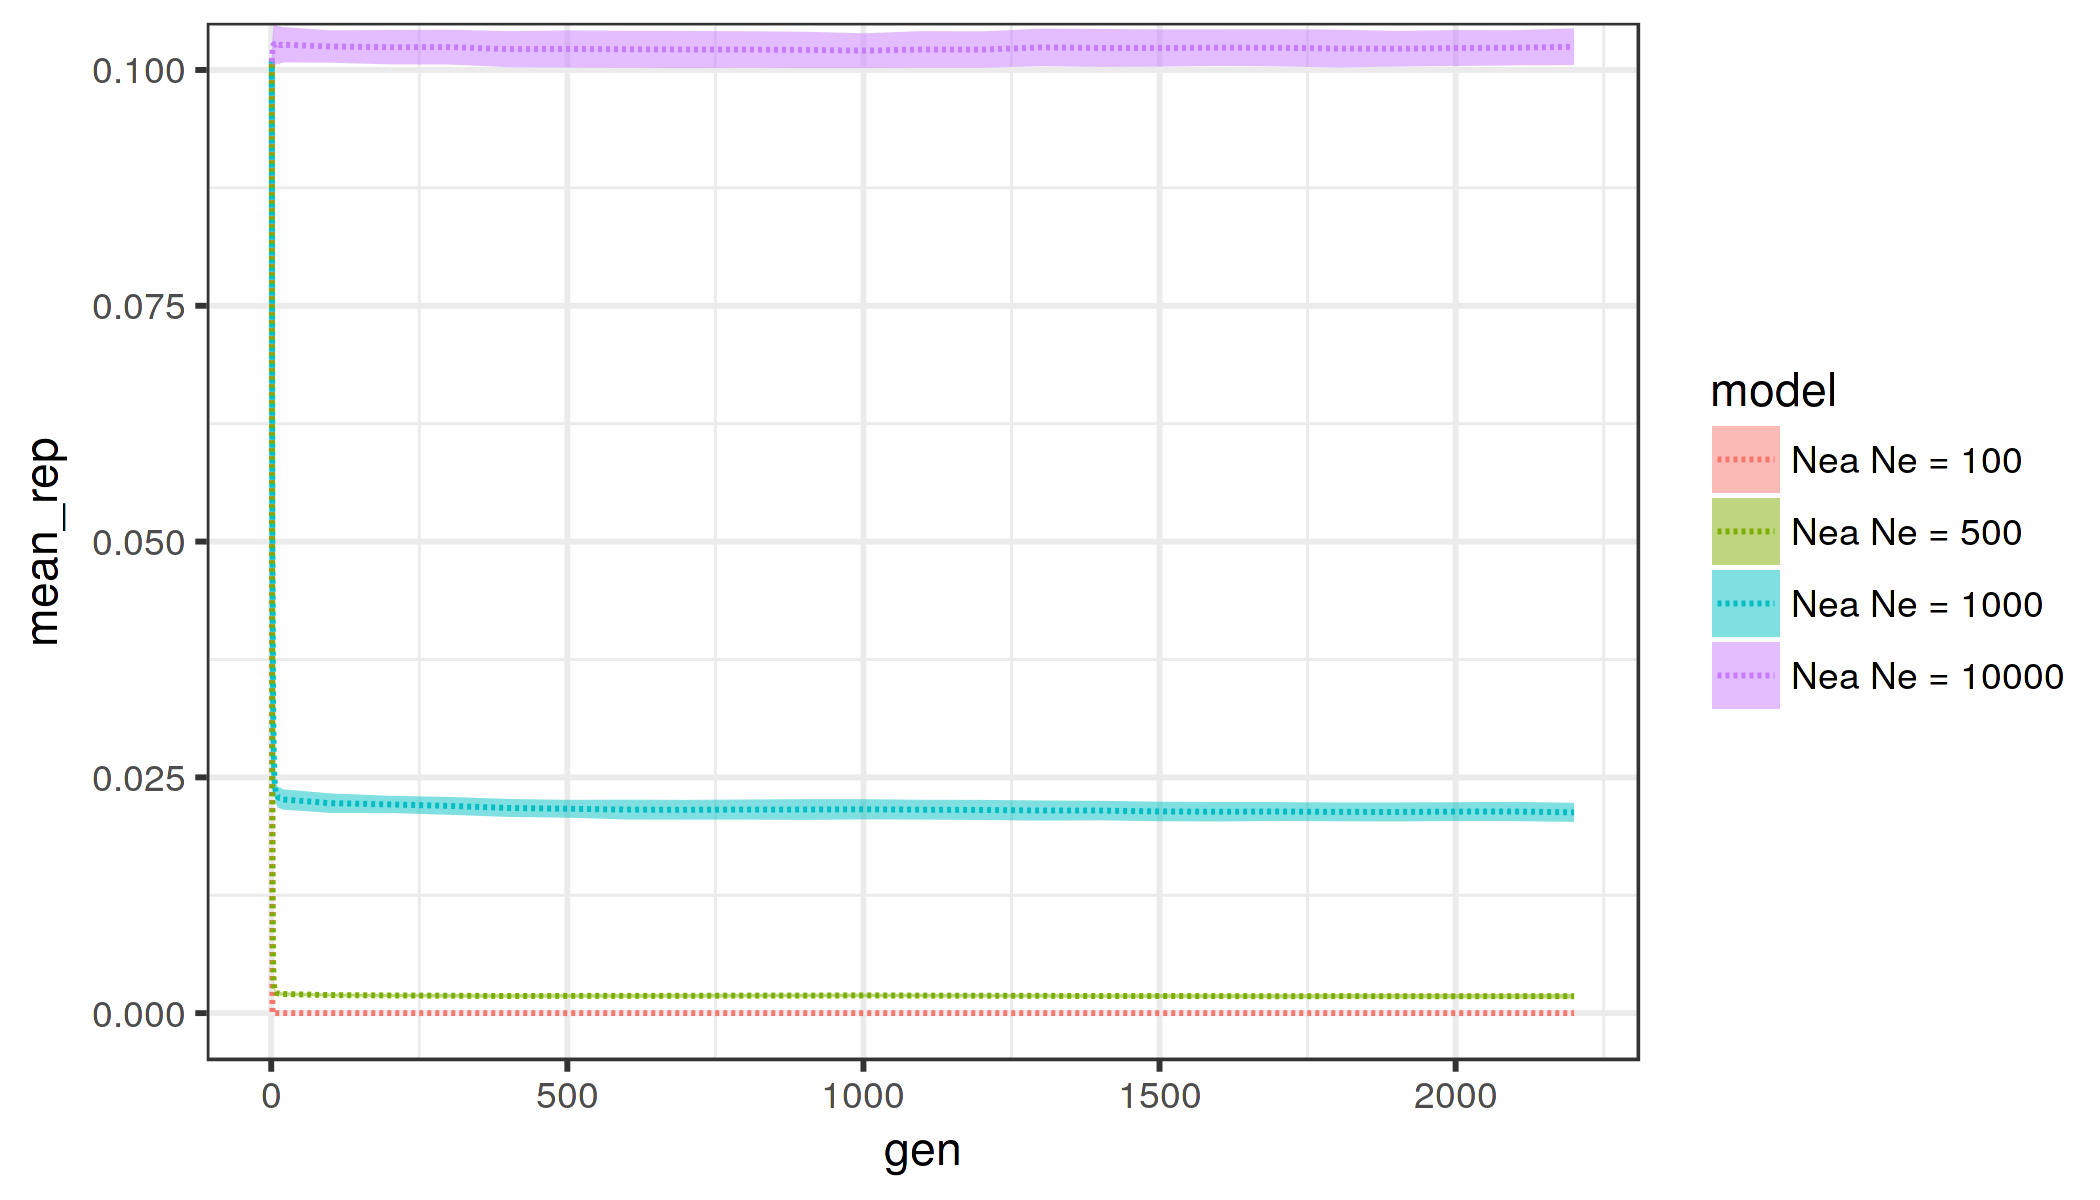

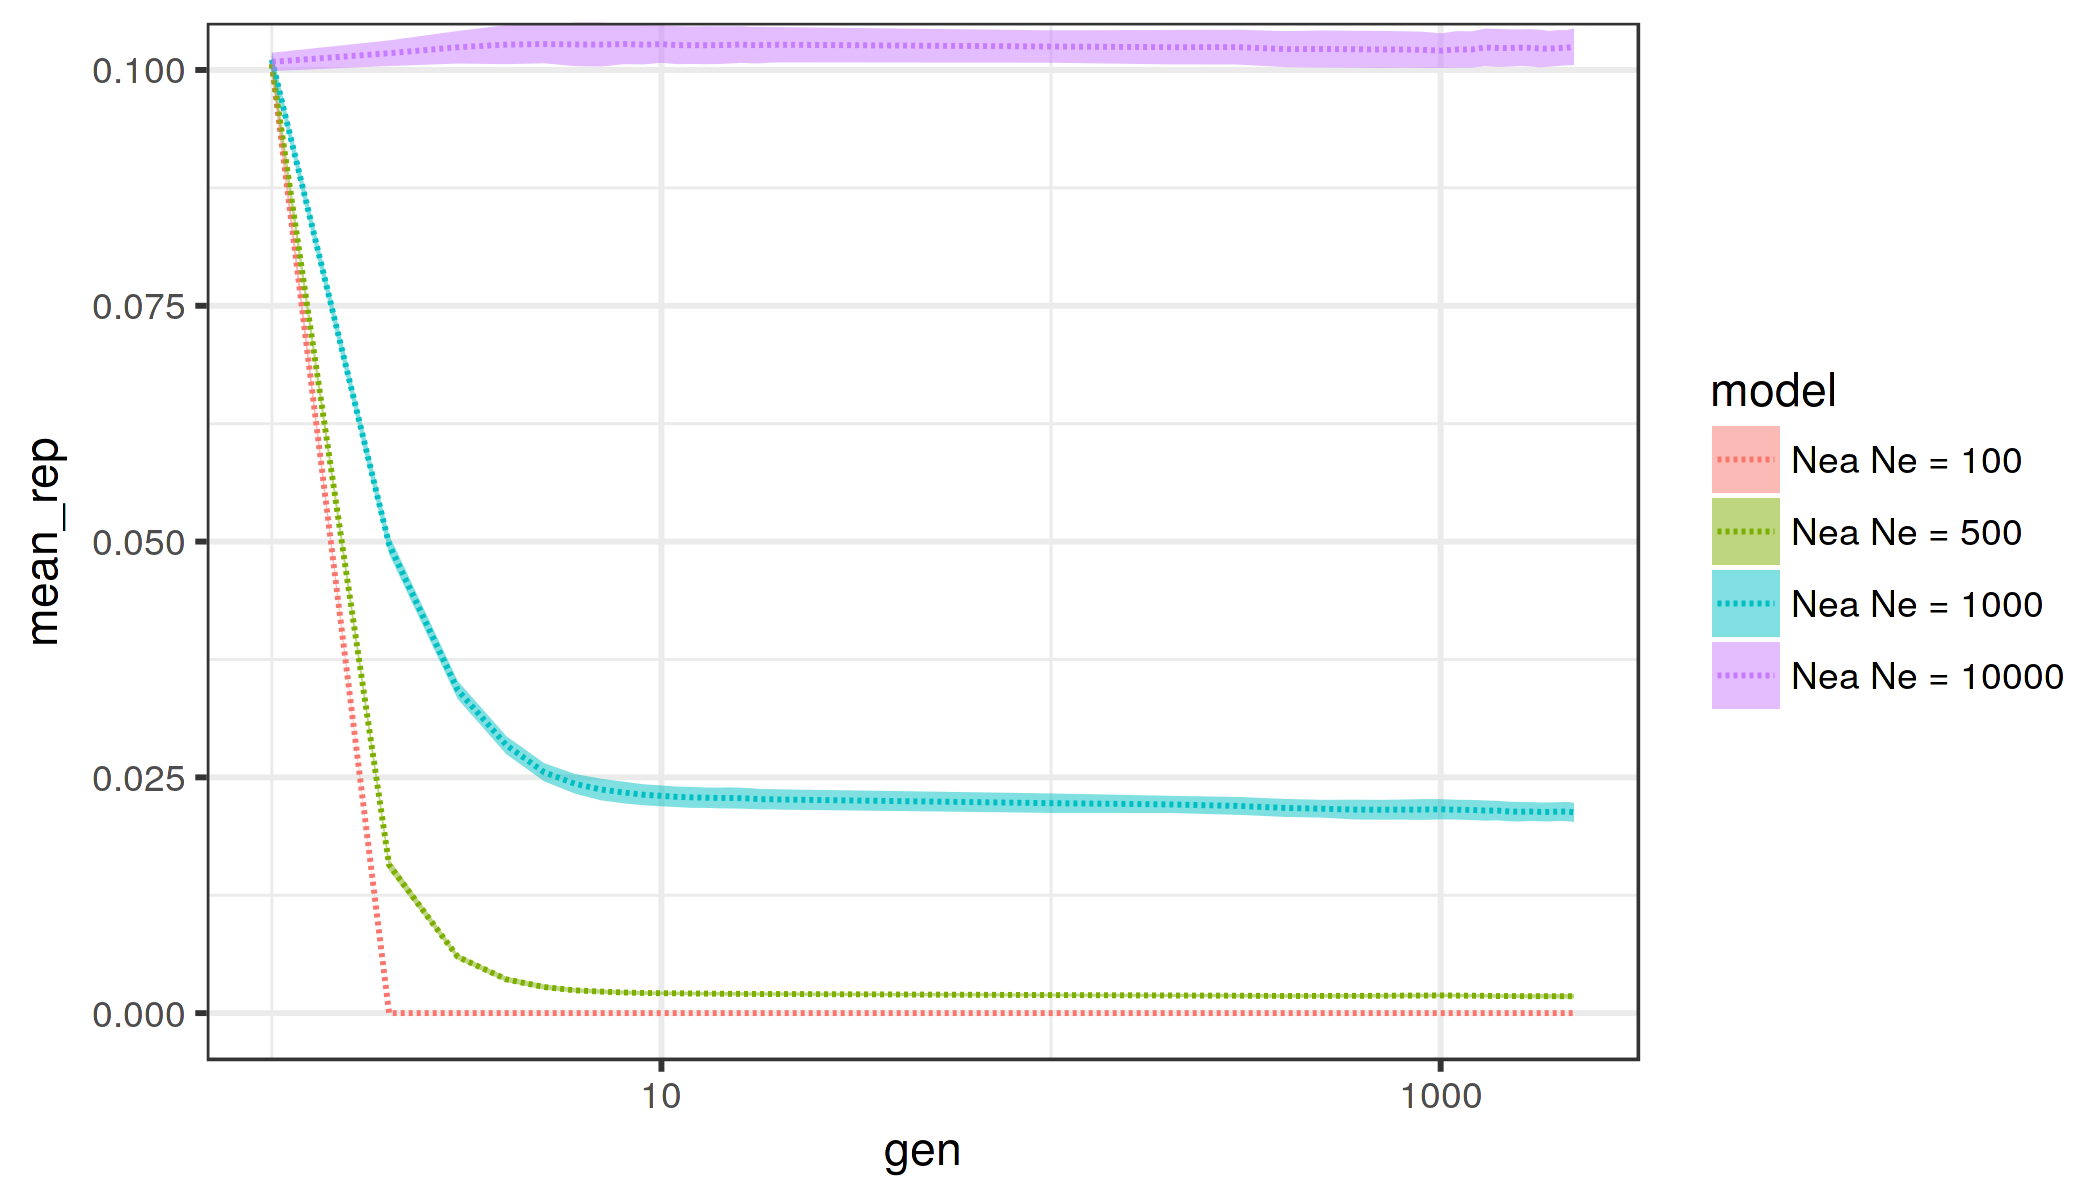

In [19]:
set_dim(7, 4, 300)

p <- list.files(here("data/simulations"), pattern = "^traj_Ne*", full.names = TRUE) %>%
map_dfr(~ sm(read_tsv(.x)) %>% mutate(model = str_replace(basename(.x), "traj_", "") %>% str_replace("_exon.*", "") %>% str_replace("Ne_", "Nea Ne = "))) %>%
mutate(model = fct_relevel(model, "Nea Ne = " %+% c(100, 500, 1000, 10000))) %>% 
group_by(model, gen) %>% 
summarise(mean_rep=mean(mean), sd_rep=sd(mean), n_rep=n()) %>%
mutate(se_rep=sd_rep / sqrt(n_rep),
     lower_ci=mean_rep - qt(1 - (0.05 / 2), n_rep - 1) * se_rep,
     upper_ci=mean_rep + qt(1 - (0.05 / 2), n_rep - 1) * se_rep) %>% 
ggplot(aes(gen, mean_rep)) +
    geom_line(aes(color = model), linetype = 2) +
    geom_ribbon(aes(ymin=lower_ci, ymax=upper_ci, fill = model), alpha=1/2) +
    theme_bw() + coord_cartesian(y = c(0, 0.1))

p
ggsave(here("figures/figS3_Neandertal_Ne.png"), width = 8, height = 5, units = "in")

p + scale_x_log10()
ggsave(here("figures/figS3_Neandertal_Ne_log.png"), width = 8, height = 5, units = "in")

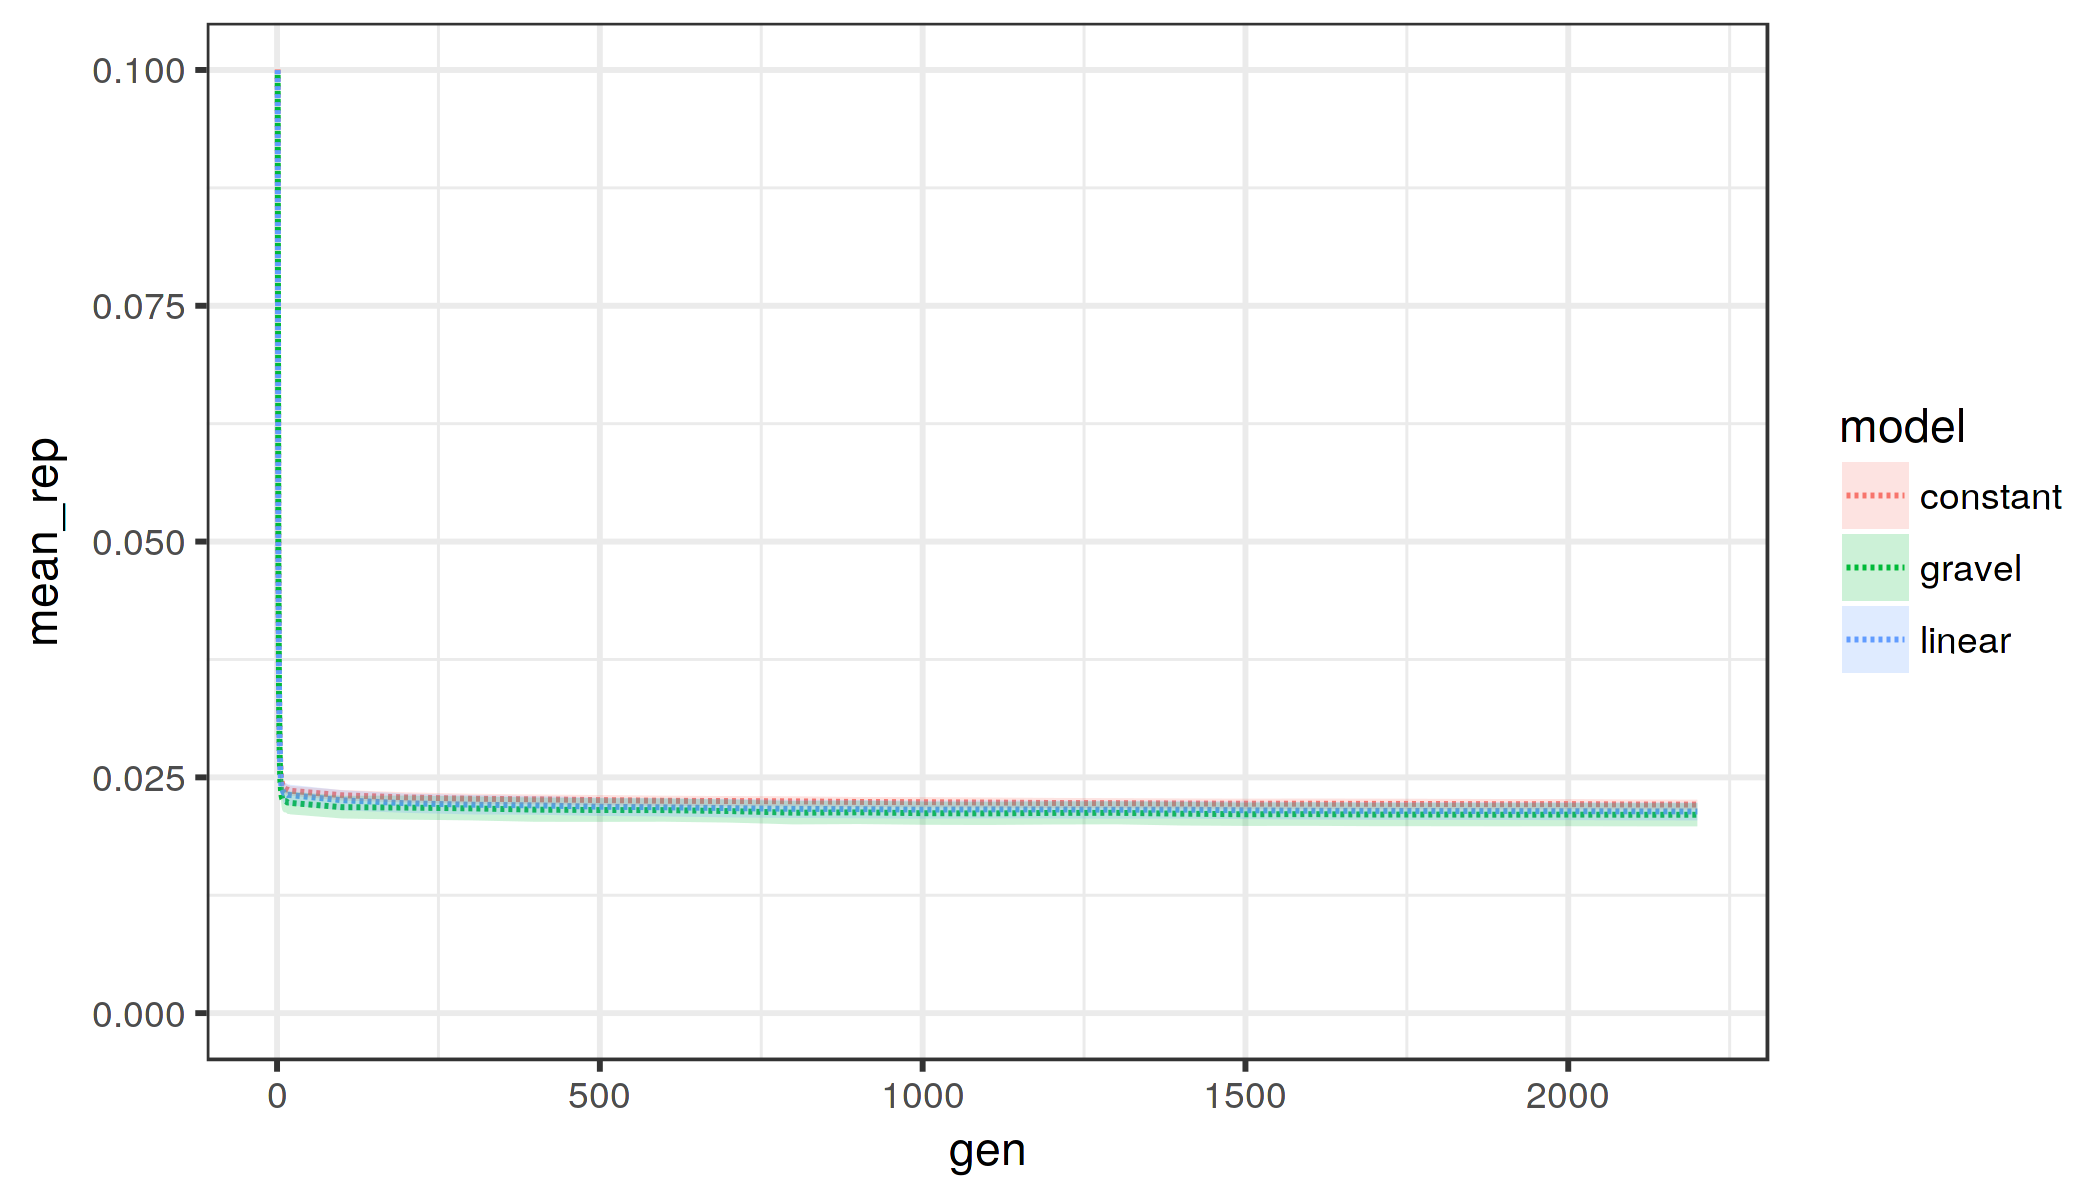

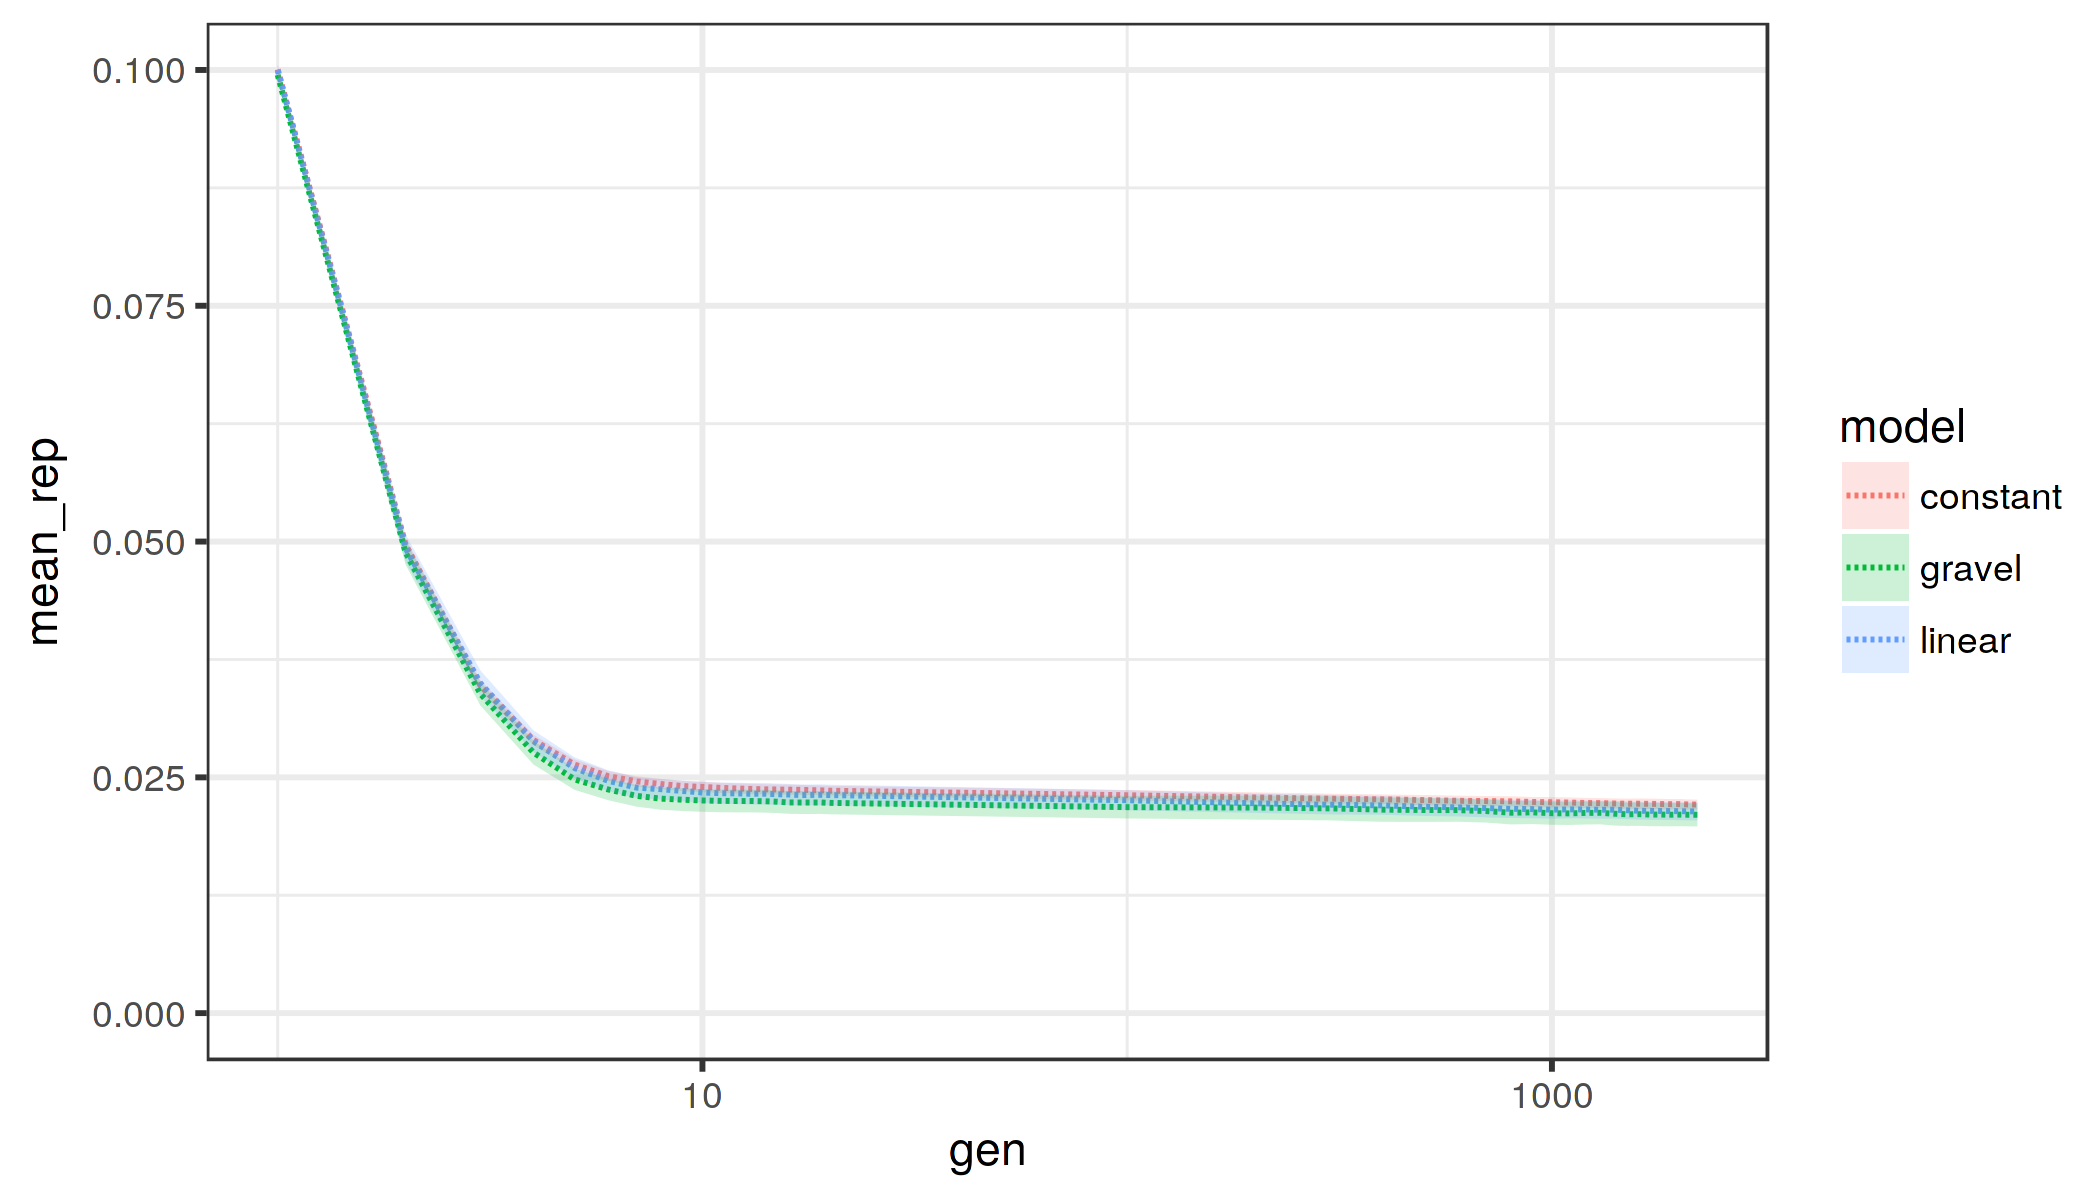

In [20]:
set_dim(7, 4, 300)

p <- bind_rows(
list.files(here("data/simulations"), pattern = "^traj_constant*", full.names = TRUE) %>% map_dfr(~ sm(read_tsv(.x)) %>% mutate(model = "constant")),
list.files(here("data/simulations"), pattern = "^traj_linear*", full.names = TRUE) %>% map_dfr(~ sm(read_tsv(.x)) %>% mutate(model = "linear")),
list.files(here("data/simulations"), pattern = "^traj_gravel*", full.names = TRUE) %>% map_dfr(~ sm(read_tsv(.x)) %>% mutate(model = "gravel"))
) %>%
group_by(model, gen) %>% 
summarise(mean_rep=mean(mean), sd_rep=sd(mean), n_rep=n()) %>%
mutate(se_rep=sd_rep / sqrt(n_rep),
     lower_ci=mean_rep - qt(1 - (0.05 / 2), n_rep - 1) * se_rep,
     upper_ci=mean_rep + qt(1 - (0.05 / 2), n_rep - 1) * se_rep) %>% 
ggplot(aes(gen, mean_rep)) +
    geom_line(aes(color = model), linetype = 2) +
    geom_ribbon(aes(ymin=lower_ci, ymax=upper_ci, fill = model), alpha=1/5) +
    theme_bw() + coord_cartesian(y = c(0, 0.1))

p
ggsave(here("figures/figS4_human_Ne.png"), width = 8, height = 5, units = "in")

p + scale_x_log10()
ggsave(here("figures/figS4_human_Ne_log.png"), width = 8, height = 5, units = "in")

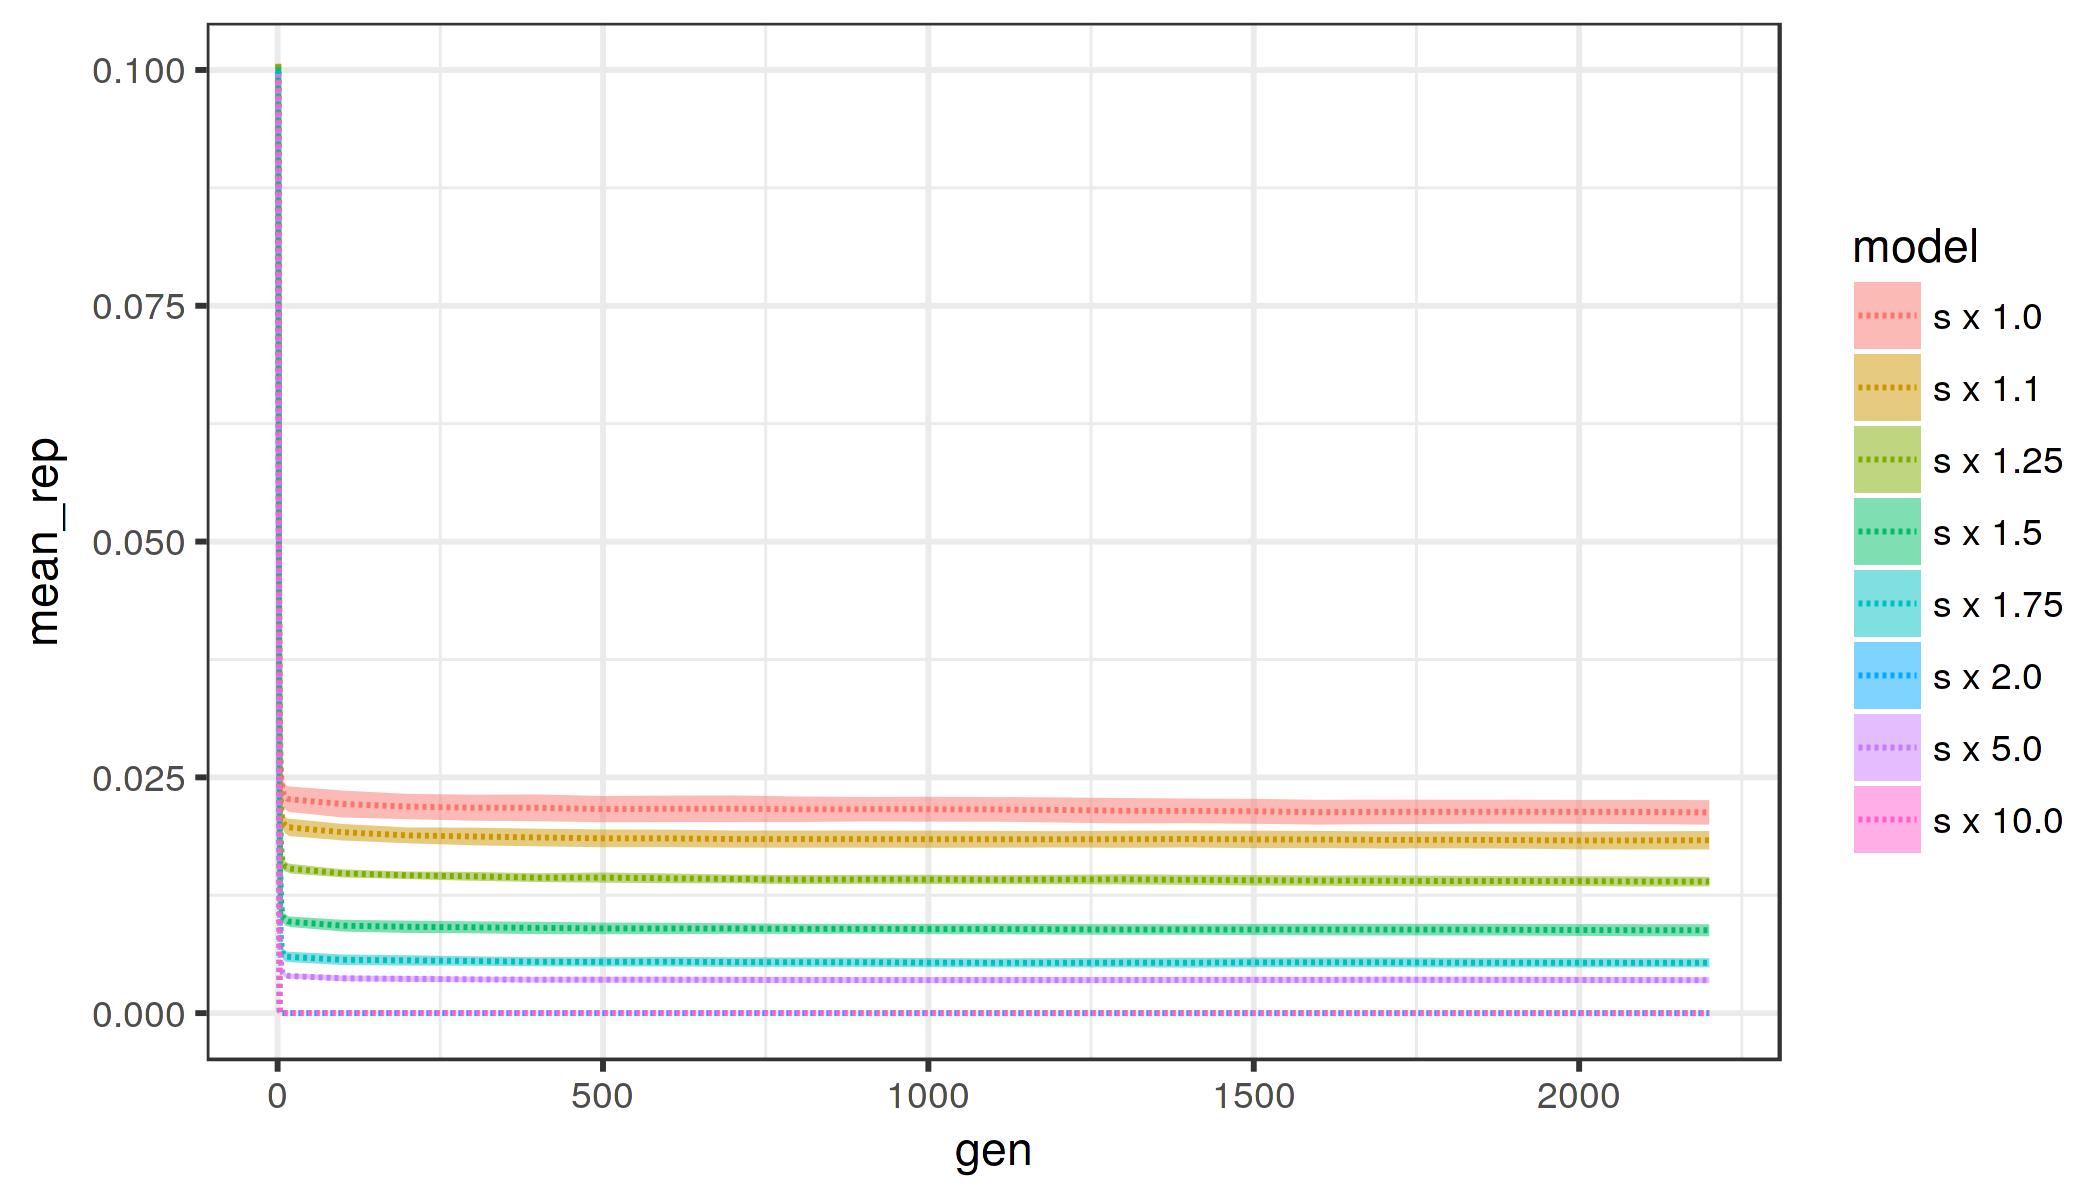

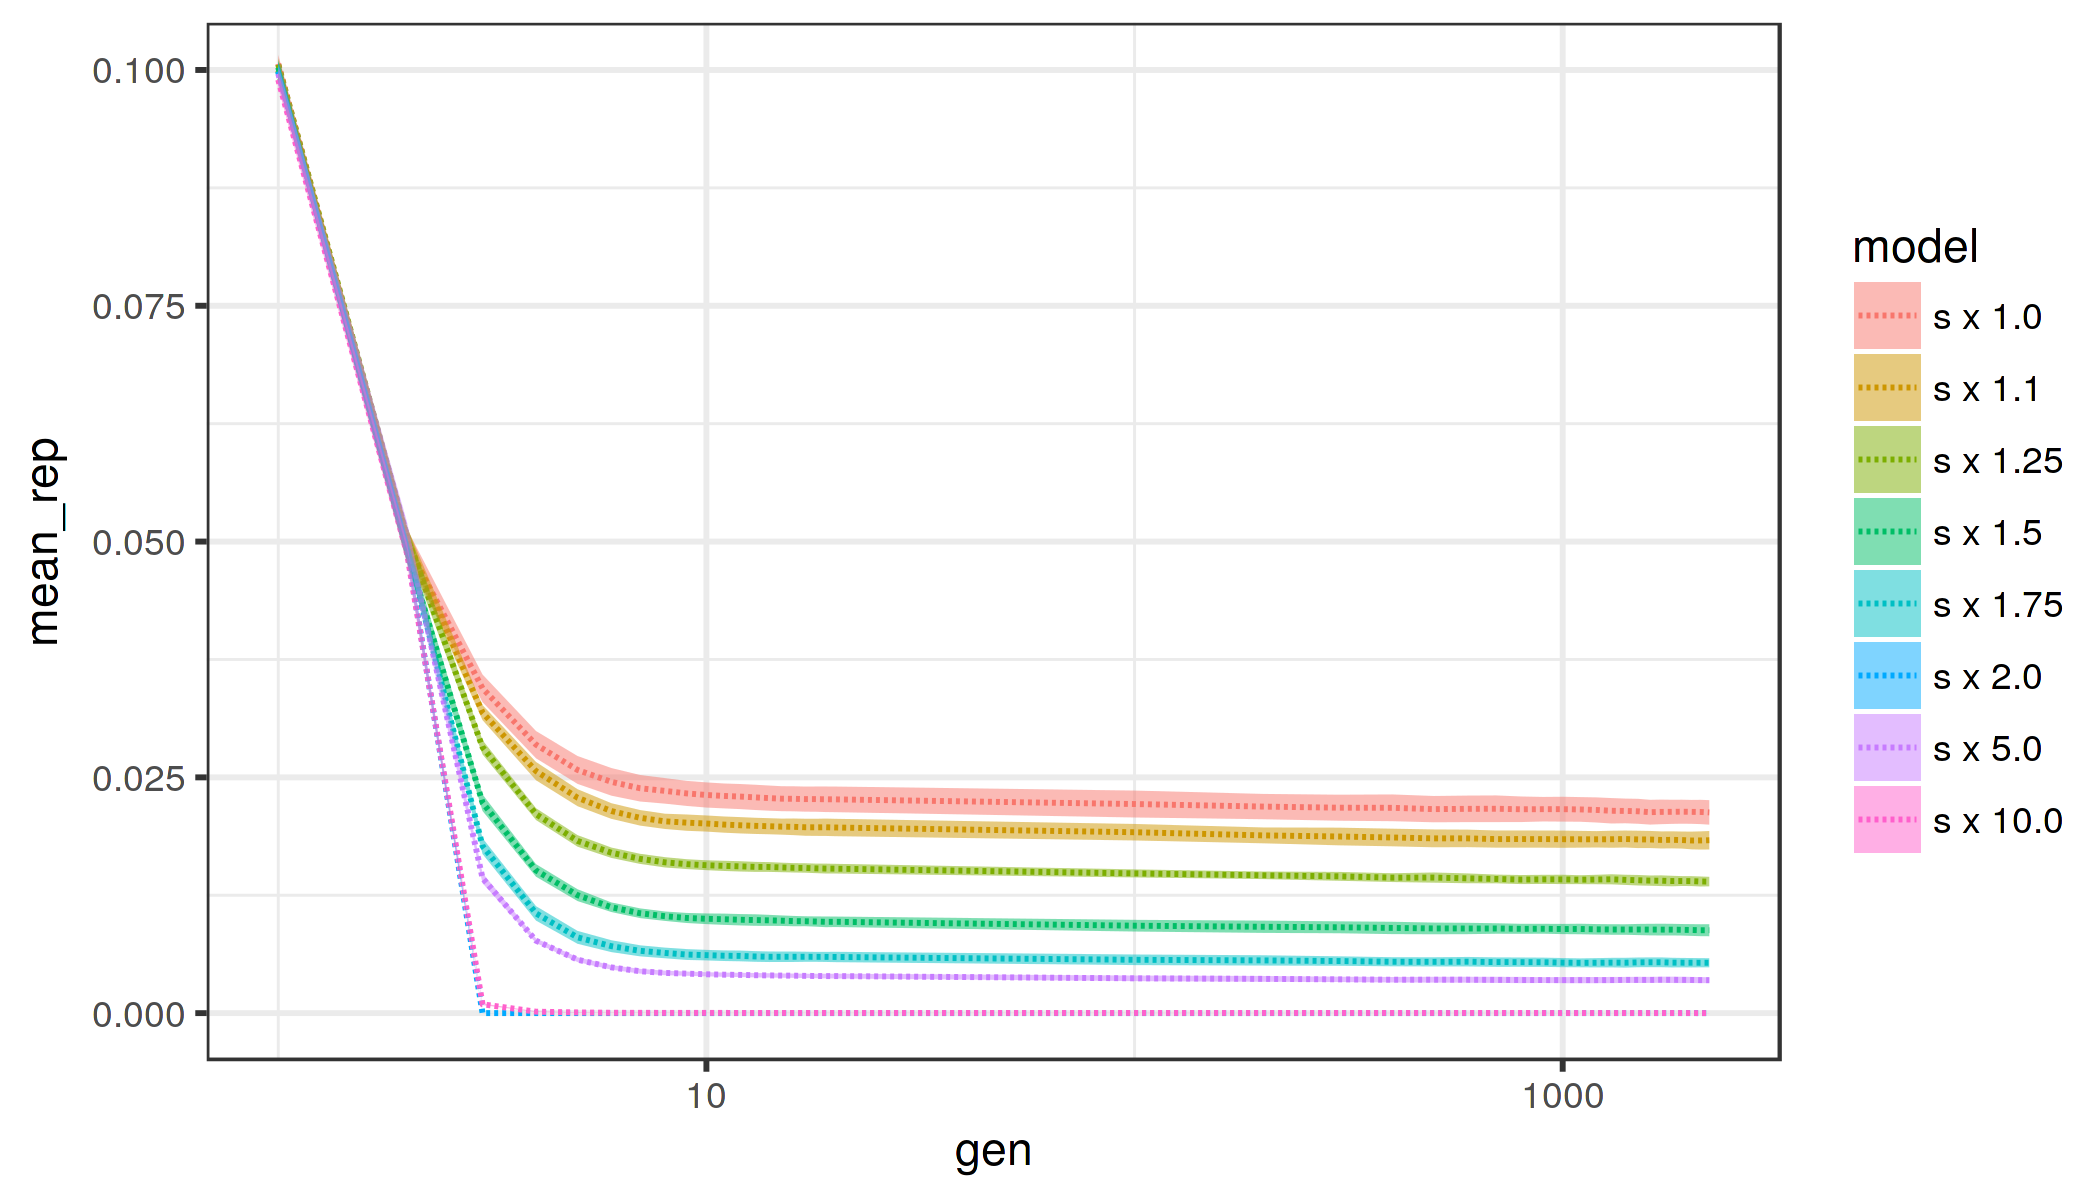

In [21]:
set_dim(7, 4, 300)

p <- list.files(here("data/simulations"), pattern = "^traj_mult*", full.names = TRUE) %>%
map_dfr(~ sm(read_tsv(.x)) %>% mutate(model = str_replace(basename(.x), "data/simulations/traj_", "") %>%
                                      str_replace("_rep_.*", "") %>% str_replace("traj_mult_", "s x "))) %>%
group_by(model, gen) %>% 
summarise(mean_rep=mean(mean), sd_rep=sd(mean), n_rep=n()) %>%
mutate(se_rep=sd_rep / sqrt(n_rep),
     lower_ci=mean_rep - qt(1 - (0.05 / 2), n_rep - 1) * se_rep,
     upper_ci=mean_rep + qt(1 - (0.05 / 2), n_rep - 1) * se_rep) %>%
ungroup %>%
mutate(model = factor(model, labels = "s x " %+% c("1.0", 1.1, 1.25, 1.5, 1.75, "2.0", "5.0", "10.0"))) %>%
ggplot(aes(gen, mean_rep)) +
    geom_line(aes(color = model), linetype = 2) +
    geom_ribbon(aes(ymin=lower_ci, ymax=upper_ci, fill = model), alpha=1/2) +
    theme_bw() + coord_cartesian(y = c(0, 0.1))

p
ggsave(here("figures/figS5_bumping_up_DFE.png"), width = 8, height = 5, units = "in")

p + scale_x_log10()
ggsave(here("figures/figS5_bumping_up_DFE_log.png"), width = 8, height = 5, units = "in")

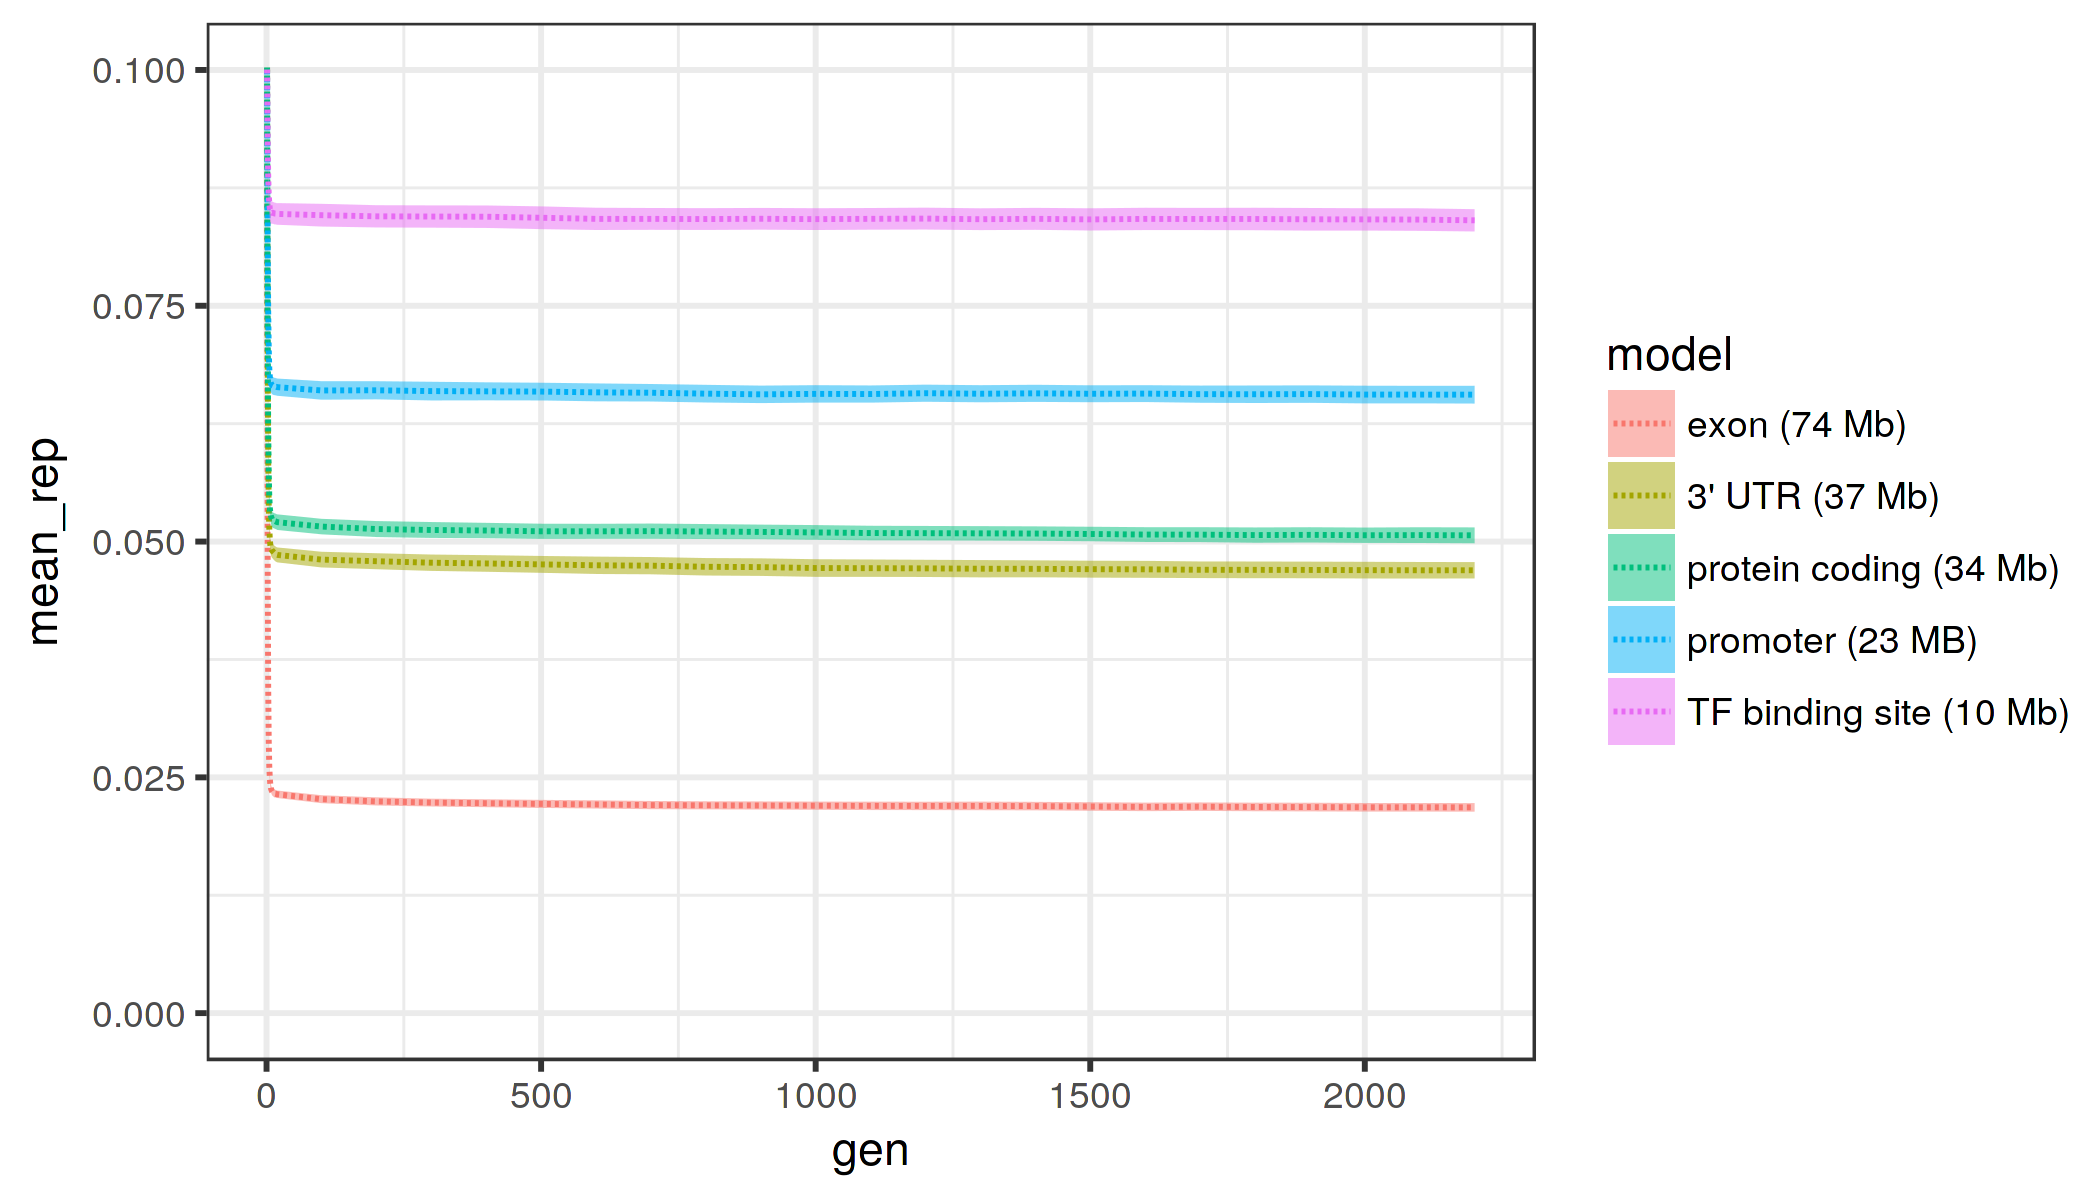

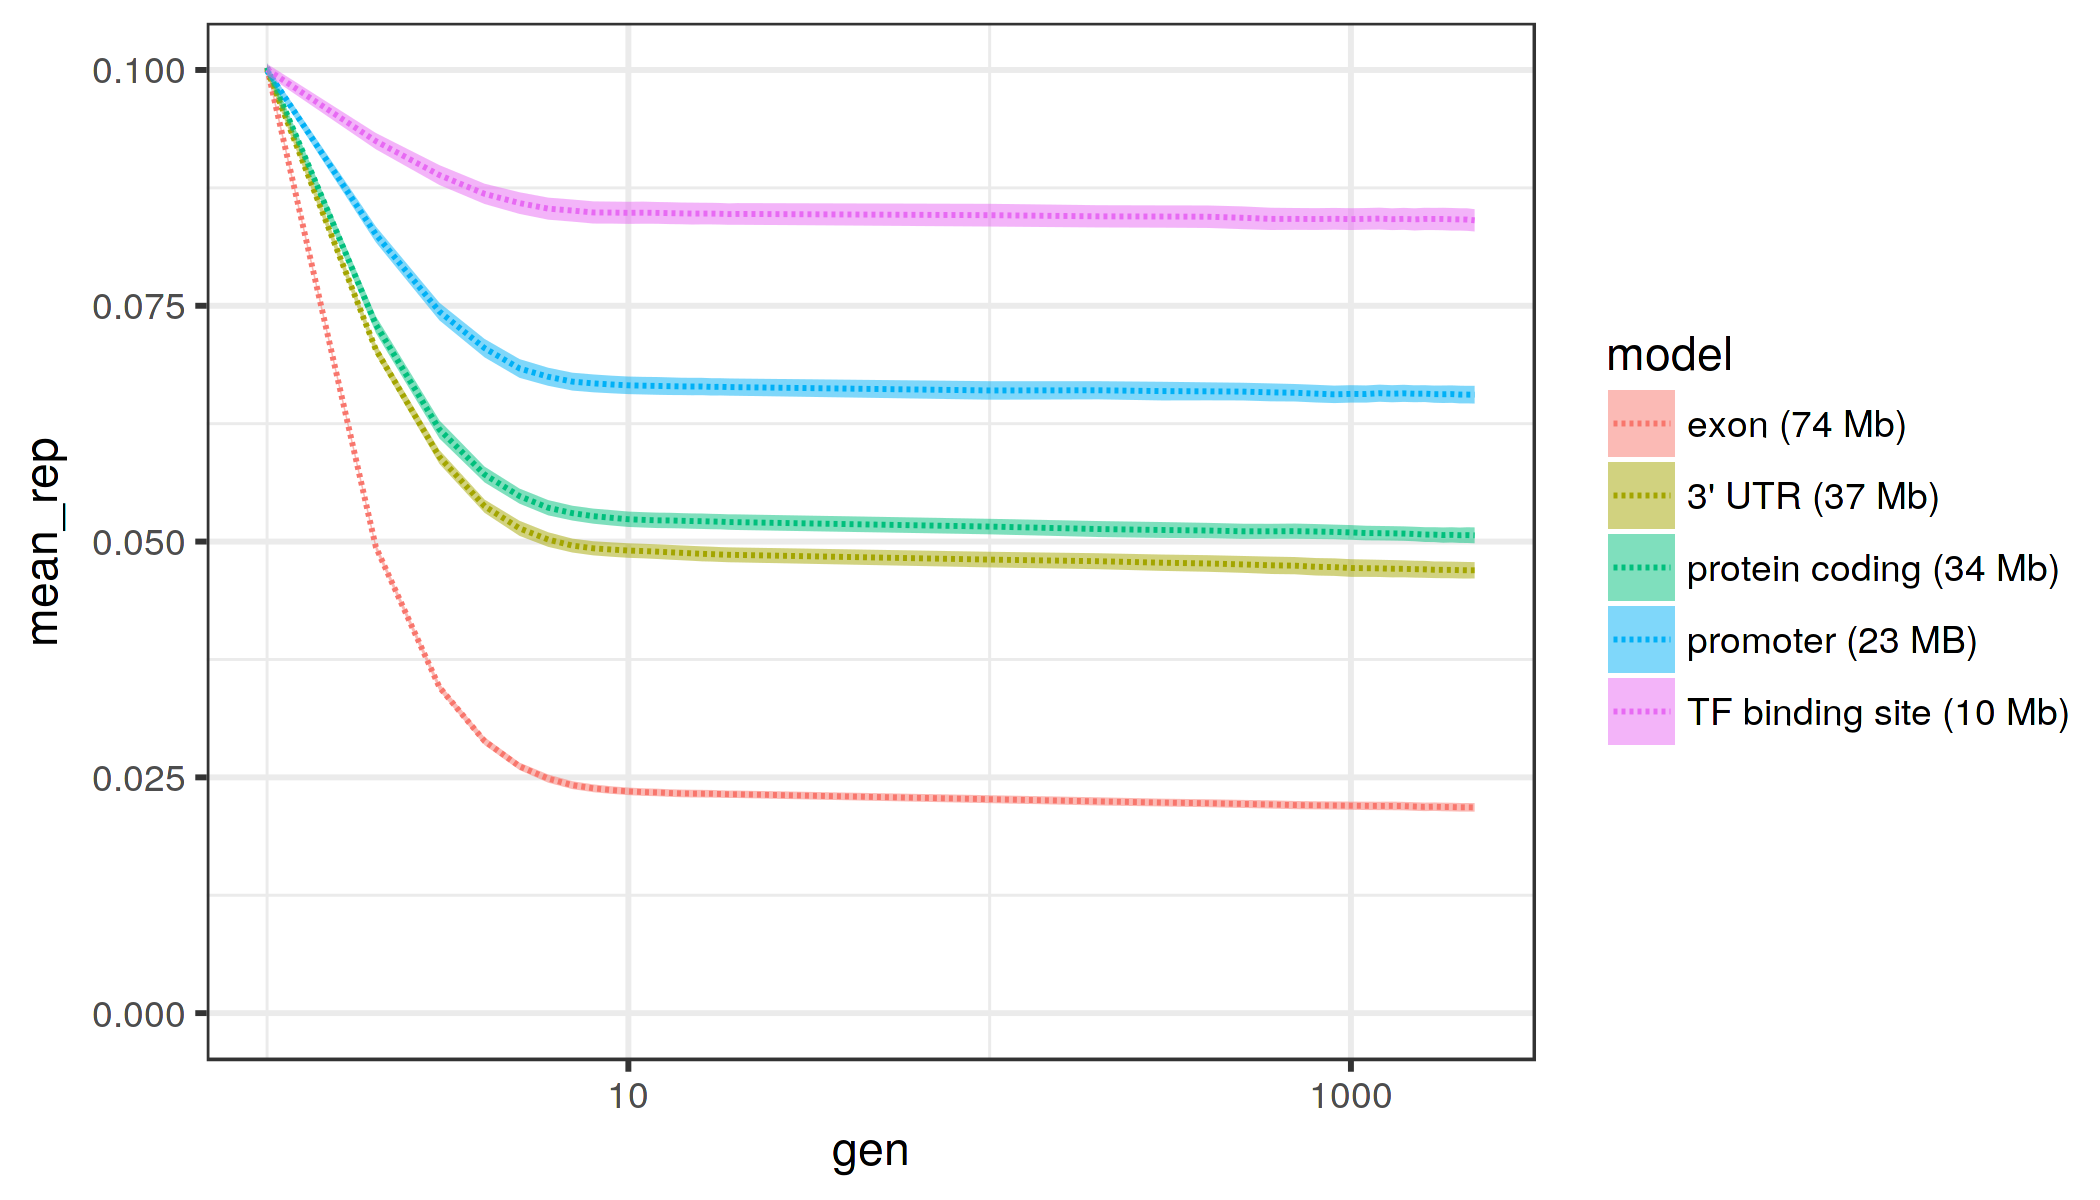

In [22]:
set_dim(7, 4, 300)

p <- lapply(c("exon", "protein_coding", "tf_binding_site", "utr3", "promoter"), function(region) {
    list.files(here("data/simulations"), pattern = "^traj_" %+% region %+% "*", full.names = TRUE) %>%
        map_dfr(~ sm(read_tsv(.x)) %>% mutate(model = str_replace(basename(.x), "traj_", "") %>%
                                              str_replace("_rep_.*", "")))
    }) %>%
bind_rows %>%
group_by(model, gen) %>% 
summarise(mean_rep=mean(mean), sd_rep=sd(mean), n_rep=n()) %>%
mutate(se_rep=sd_rep / sqrt(n_rep),
     lower_ci=mean_rep - qt(1 - (0.05 / 2), n_rep - 1) * se_rep,
     upper_ci=mean_rep + qt(1 - (0.05 / 2), n_rep - 1) * se_rep) %>%
ungroup %>% 
mutate(model = case_when(model == "exon" ~ "exon (74 Mb)",
                         model == "promoter" ~ "promoter (23 MB)",
                         model == "protein_coding" ~ "protein coding (34 Mb)",
                         model == "tf_binding_site" ~ "TF binding site (10 Mb)",
                         model == "utr3" ~ "3' UTR (37 Mb)")) %>%
mutate(model = fct_relevel(model, c("exon (74 Mb)", "3' UTR (37 Mb)", "protein coding (34 Mb)",
                             "promoter (23 MB)", "TF binding site (10 Mb)"))) %>% 
ggplot(aes(gen, mean_rep)) +
    geom_line(aes(color = model), linetype = 2) +
    geom_ribbon(aes(ymin=lower_ci, ymax=upper_ci, fill = model), alpha=1/2) +
    theme_bw() + coord_cartesian(y = c(0, 0.1))

p
ggsave(here("figures/figS6_amounts_of_del_sequence.png"), width = 8, height = 5, units = "in")

p + scale_x_log10()
ggsave(here("figures/figS6_amounts_of_del_sequence_log.png"), width = 8, height = 5, units = "in")

## Effective population size models

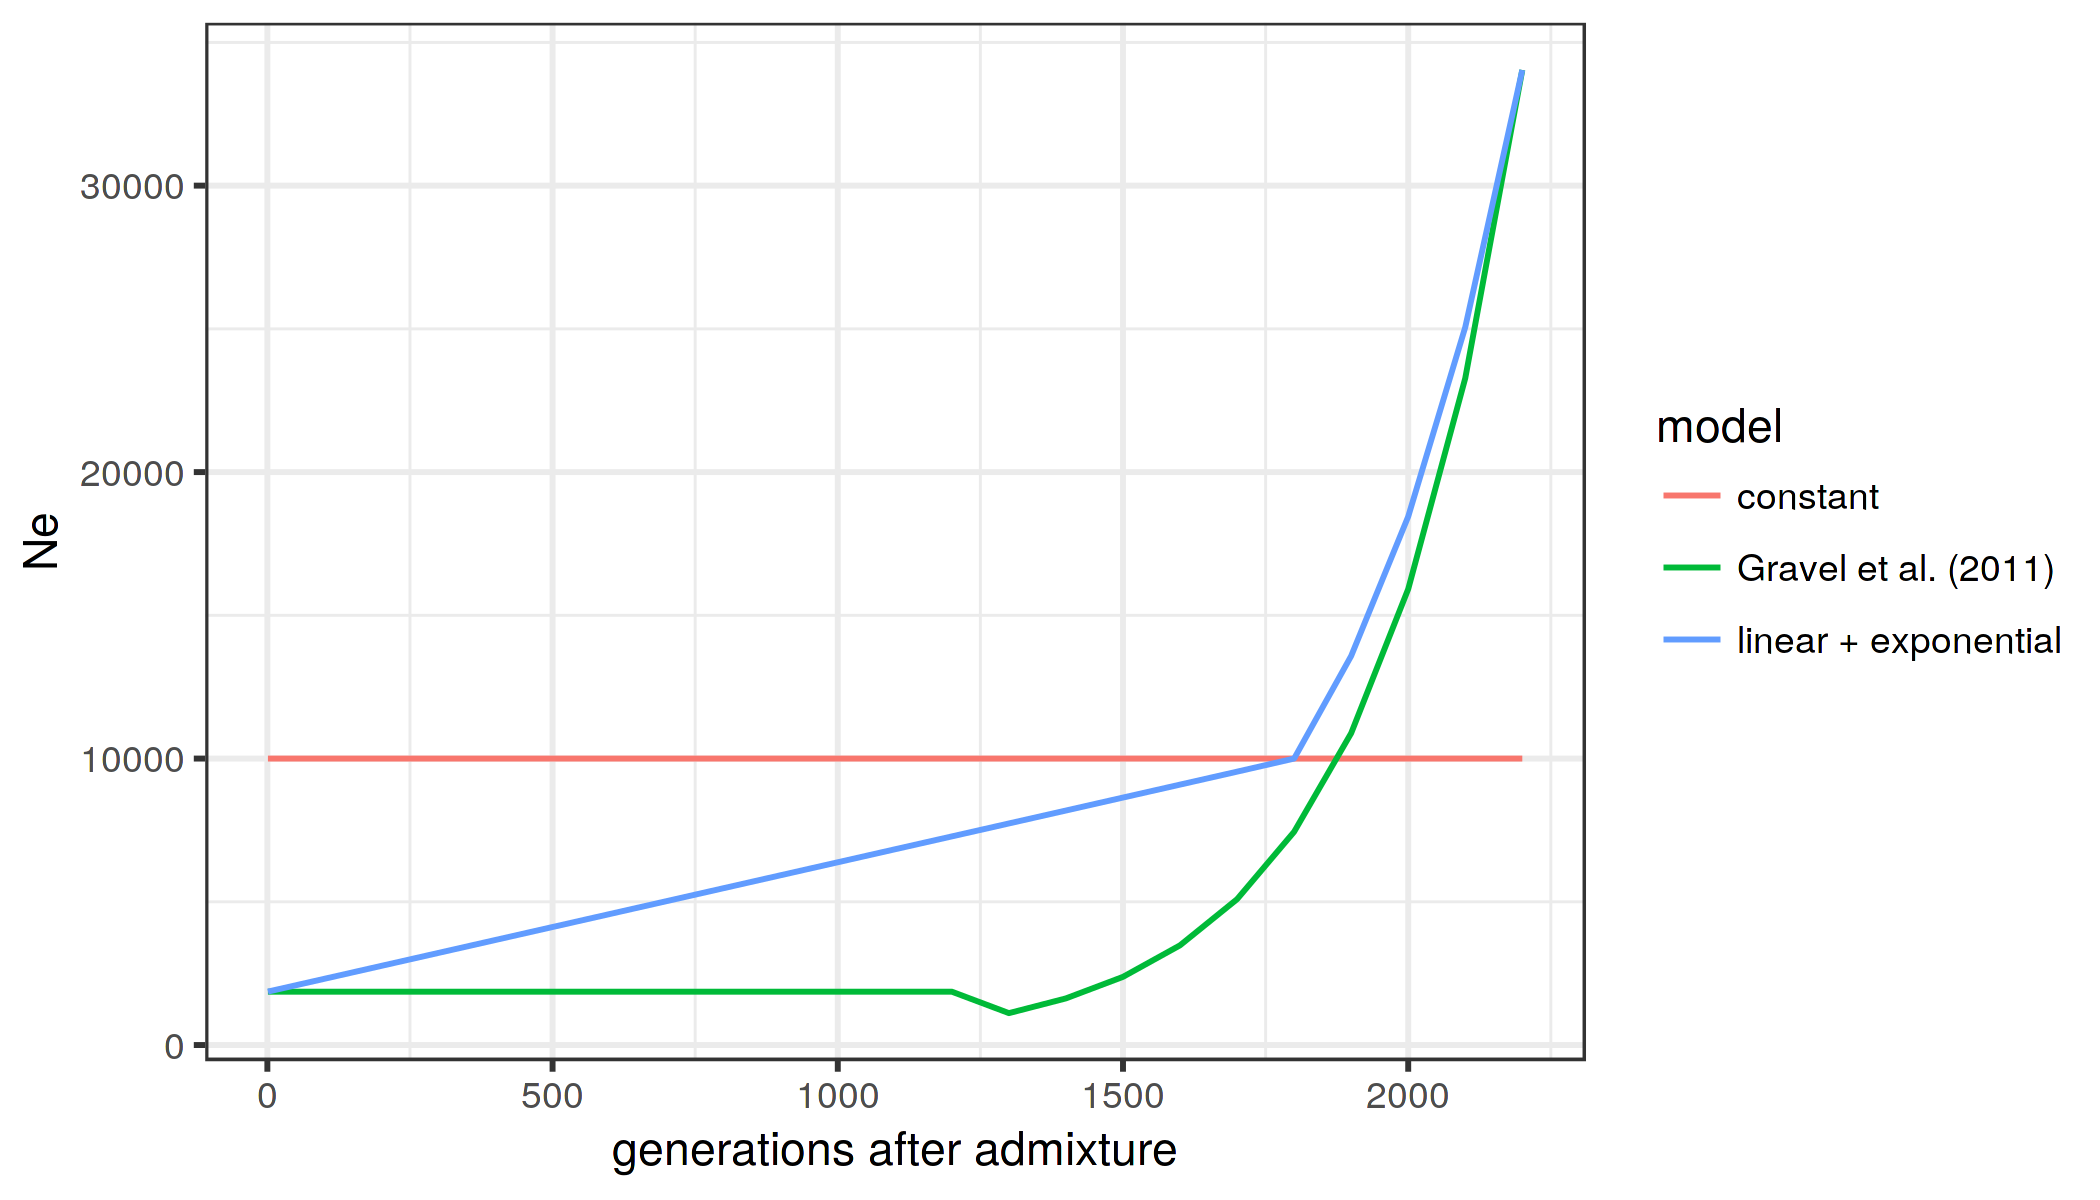

In [23]:
set_dim(7, 4, 300)

bind_rows(
    sm(read_tsv(here("data/simulations", "traj_constant_exon_rep_1_trajectory.txt"))) %>% mutate(model = "constant"),
    sm(read_tsv(here("data/simulations", "traj_linear_exon_rep_1_trajectory.txt"))) %>% mutate(model = "linear + exponential"),
    sm(read_tsv(here("data/simulations", "traj_gravel_exon_rep_1_trajectory.txt"))) %>% mutate(model = "Gravel et al. (2011)")
)  %>%
ggplot(aes(gen, Ne, color = model)) + geom_line() + xlab("generations after admixture") + theme_bw()

ggsave(here("figures/figS7_nonafrican_demographic_models.png"), width = 8, height = 5, units = "in")